<h1 id="ref_1">Описание проекта</h1>

**Аннотация**

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

*Необходимо разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность*.

**Ход исследования**:

Данные получаем из файлов:

| Исходный файл   | Описание|
|:----------------|:-----------------|
| market_file.csv | Данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении|
| market_money.csv| Данные о выручке, которую получает магазин с покупателя|
| market_time.csv | Данные о времени (в минутах), которое покупатель провёл на сайте в течение периода|
| money.csv       | Данные о среднемесячной прибыли от продаж каждому покупателю за последние 3 месяца|

О качестве данных ничего не известно, поэтому перед тем как приступать к исследованию, проводится общий обзор данных.

Проводится проверка данных на ошибки/аномалии. На этапе предобработки данных анализируются возможности исправить ошибки/аномалии в данных, так, чтобы это не привело к искажению реузльтатов исследования.

Производится исследовательский и статистический анализ данных, анализируются наличие "выбросов" в данных, необычное распределение количественных признаков или другие особенности.

Производится корреляционный анализ данных, по итогам которого будет сформирован набор входных признаков для будущих моделей машинного обучения.

*Задача исследования решается в два этапа*:

1. Разрабатывается модель машинного обучения, которая предскажет вероятность снижения покупательской активности клиентов.
2. Выделяется и анализируется сегмент покупателей (один или несколько) и предлагается способ увеличения покупательской активности в сегменте.

**Таким образом, исследование будет содержать следующие шаги**:

- Общий обзор данных;
- Предобработка данных;
- Исследовательский анализ данных;
- Корреляционный анализ данных;
- Построение модели машинного обучения;
- Анализ выбранного сегмента(ов) покупателей и разработка способа увеличения покупательской активности в сегменте(ах).
- Итоговые выводы и рекомендации.

<h1 id="ref_2">Импорт библиотек</h1>

In [1]:
# импорт библиотек
import os
import pandas as pd
import seaborn as sns
import numpy as np
import math
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    f1_score,
    confusion_matrix
)

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    StratifiedKFold
)
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler
)
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline

from statsmodels.stats.outliers_influence import variance_inflation_factor
from itertools import combinations

!pip install phik --quiet
from phik import resources

!pip install shap --quiet
import shap

from IPython.display import display, HTML

pd.options.display.float_format = '{:,.3f}'.format

# константы
RANDOM_STATE = 99
TEST_SIZE = 0.25

<h1 id="ref_3">Открытие таблиц, общая информация о данных</h1>

## Чтение данных из csv-файлов

In [2]:
# списки путей и параметров
inp_file_path_local = [
    'datasets/market_file.csv',
    'datasets/market_money.csv',
    'datasets/market_time.csv',
    'datasets/money.csv']

inp_file_path_global = [
    'https://code.s3.yandex.net/datasets/market_file.csv',
    'https://code.s3.yandex.net/datasets/market_money.csv',
    'https://code.s3.yandex.net/datasets/market_time.csv',
    'https://code.s3.yandex.net/datasets/money.csv']

sep_list = [',', ',', ',', ';'] # разделители полей
dec_list = ['.', '.', '.', ','] # разделители дробной части числа

# словарь для хранения датафреймов
df_all = {}
names_list = []

# загрузка файлов - или локально или из интернета
for local_path, url_path, sep, dec in zip(inp_file_path_local,
                                          inp_file_path_global,
                                          sep_list,
                                          dec_list):
    # определяем имя переменной по имени файла без расширения
    name = os.path.splitext(os.path.basename(local_path))[0]
    if os.path.exists(local_path):
        df_inp = pd.read_csv(local_path, sep=sep, decimal=dec)
        print('Успешно загружен файл:', local_path)
    else:
        df_inp = pd.read_csv(url, sep=sep, decimal=dec)
        print('Успешно загружен файл:', url_path)
    df_all[name] = df_inp
    names_list.append(name)

print(f'Названия переменных, в которые загружены данные из файлов:\n{names_list}')

Успешно загружен файл: datasets/market_file.csv
Успешно загружен файл: datasets/market_money.csv
Успешно загружен файл: datasets/market_time.csv
Успешно загружен файл: datasets/money.csv
Названия переменных, в которые загружены данные из файлов:
['market_file', 'market_money', 'market_time', 'money']


## Первичный анализ данных из csv-файлов

In [3]:
# фукнция для первичного просмотра и анализа данных в таблице
def df_data_first_view(df,
                       head_tail=True,
                       n_head=3,
                       n_tail=3,
                       duplicates=True,
                       summary=True):
    if head_tail:
        # первые и последние строки датасета
        n_head = max(n_head, 3)
        n_tail = max(n_tail, 3)

        print(f"Первые {n_head} и последние {n_tail} строк датасета")
        display(pd.concat([df.head(n_head), df.tail(n_tail)]))
    
    if summary:
        # создаем расширенную информацию о данных
        total_rows = len(df)
        non_null_counts = df.count()
        missing_counts = total_rows - non_null_counts
        unique_counts = df.nunique(dropna=False)
        dtypes_data = df.dtypes
        
        # итоговая таблица с информацией о данных
        extended_info = pd.DataFrame({
            'column': df.columns,
            'non-null_count': non_null_counts.values,
            'missing_count': missing_counts.values,
            'unique_count': unique_counts.values,
            'data_type': dtypes_data.values})
        
        # вывод расширенной информации о данных
        print('Информация о данных')
        display(extended_info)

    if duplicates:
        # подсчет числа и вывод на экран явных дубликатов
        total_duplicates = df.duplicated().sum()
        if total_duplicates == 0:
            print('Явных дубликатов нет')
        else:
            print('Присуствуют явные дубликаты в количестве', total_duplicates, 'шт.')
            print('Дублирующиеся строки (все)')
            display(df[df.duplicated(keep=False)])

    return

In [4]:
# вывод основной информации о данных
# в цикле - по всем загруженным датасетам
for name_df in names_list:
    display(HTML("<div style='border-bottom: 2px solid green; margin: 10px 0;'></div>"))
    display(HTML(f"<b style='color: green;'>Данные из файла: {name_df}.csv</b>"))
    df_data_first_view(df_all[name_df],
                       head_tail=True,
                       n_head=3,
                       n_tail=3,
                       duplicates=True,
                       summary=True)

Первые 3 и последние 3 строк датасета


id Покупательская активность Тип сервиса Разрешить сообщать  \
0     215348                 Снизилась     премиум                 да   
1     215349                 Снизилась     премиум                 да   
2     215350                 Снизилась   стандартт                нет   
1297  216645           Прежний уровень    стандарт                 да   
1298  216646           Прежний уровень    стандарт                 да   
1299  216647           Прежний уровень     премиум                 да   

      Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  \
0                  3.400                     5           121   
1                  4.400                     4           819   
2                  4.900                     3           539   
1297               4.100                     3           586   
1298               6.300                     5           645   
1299               4.000                     5           906   

      Акционные_покупки            Популярная_категория  \
0                 0.000                Товары для детей   
1                 0.750                Товары для детей   
2                 0.140               Домашний текстиль   
1297              0.200               Домашний текстиль   
1298              0.120  Техника для красоты и здоровья   
1299              0.940  Техника для красоты и здоровья   

      Средний_просмотр_категорий_за_визит  Неоплаченные_продукты_штук_квартал  \
0                                       6                                   2   
1                                       4                                   4   
2                                       5                                   2   
1297                                    3                                   2   
1298                                    3                                   3   
1299                                    4                                   5   

      Ошибка_сервиса  Страниц_за_визит  
0                  1                 5  
1                  2                 5  
2                  1                 5  
1297               5                 7  
1298               5                 7  
1299               3                12

Информация о данных


column  non-null_count  missing_count  \
0                                    id            1300              0   
1             Покупательская активность            1300              0   
2                           Тип сервиса            1300              0   
3                    Разрешить сообщать            1300              0   
4                    Маркет_актив_6_мес            1300              0   
5                  Маркет_актив_тек_мес            1300              0   
6                          Длительность            1300              0   
7                     Акционные_покупки            1300              0   
8                  Популярная_категория            1300              0   
9   Средний_просмотр_категорий_за_визит            1300              0   
10   Неоплаченные_продукты_штук_квартал            1300              0   
11                       Ошибка_сервиса            1300              0   
12                     Страниц_за_визит            1300              0   

    unique_count data_type  
0           1300     int64  
1              2    object  
2              3    object  
3              2    object  
4             41   float64  
5              3     int64  
6            658     int64  
7             42   float64  
8              6    object  
9              6     int64  
10            11     int64  
11            10     int64  
12            20     int64

Явных дубликатов нет


Первые 3 и последние 3 строк датасета


id               Период   Выручка
0     215348  препредыдущий_месяц     0.000
1     215348        текущий_месяц 3,293.100
2     215348     предыдущий_месяц     0.000
3897  216647     предыдущий_месяц 4,720.000
3898  216647  препредыдущий_месяц 5,183.000
3899  216647        текущий_месяц 4,448.300

Информация о данных


column  non-null_count  missing_count  unique_count data_type
0       id            3900              0          1300     int64
1   Период            3900              0             3    object
2  Выручка            3900              0          2776   float64

Явных дубликатов нет


Первые 3 и последние 3 строк датасета


id            Период  минут
0     215348     текущий_месяц     14
1     215348  предыдцщий_месяц     13
2     215349     текущий_месяц     10
2597  216646     текущий_месяц      7
2598  216647     текущий_месяц     10
2599  216647  предыдцщий_месяц     15

Информация о данных


column  non-null_count  missing_count  unique_count data_type
0      id            2600              0          1300     int64
1  Период            2600              0             2    object
2   минут            2600              0            20     int64

Явных дубликатов нет


Первые 3 и последние 3 строк датасета


id  Прибыль
0     215348    0.980
1     215349    4.160
2     215350    3.130
1297  216645    3.290
1298  216646    4.030
1299  216647    3.280

Информация о данных


column  non-null_count  missing_count  unique_count data_type
0       id            1300              0          1300     int64
1  Прибыль            1300              0           400   float64

Явных дубликатов нет


## Описание файлов данных

---
Файл **`market_file.csv`**:

- Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

Описание данных:

- `id` — номер покупателя в корпоративной базе данных.
- `Покупательская активность` — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- `Тип сервиса` — уровень сервиса, например «премиум» и «стандарт».
- `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.
- `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.
- `Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.
- `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.
- `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца..

---
Файл **`market_money.csv`**:

- Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

Описание данных:

- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксирована выручка.
- `Выручка` — сумма выручки за период.

---
Файл **`market_time.csv`**:

- Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

Описание данных:

- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксировано общее время.
- `минут` — значение времени, проведённого на сайте, в минутах.

---
Файл **`money.csv`**:

- Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

Описание данных:

- `id` — номер покупателя в корпоративной базе данных.
- `Прибыль` — значение прибыли.

## Выводы - обзор исходных данных

**Выявленые следующие факты**:

---
1. *Пропуски в данных*:
- отсутствуют во всех таблицах.

---
2. *Наименования столбцов*:
- будут сохранены кириллические названия столбцов;
- названия столбцов будут переведены в "змеиный_регистр";
- названия столбцов будут переведены в нижний регистр.

---
3. *Явные дубликаты в данных*:
- отсутствуют во всех таблицах.

---
4. *Неявные дубликаты в данных*:
- требуется отдельная проверка по данному фактору.

---
5. *Прочие выявленные факторы (разный размер таблиц)*:
- общее число уникальных `id` клиентов: 1300;
- Таблицы `market_file` и `money` имеют по 1300 записей;
- Таблица `market_money` содержит 3900 непустых записей, при уникальных `id` в кол-ве 1300:
  - 3900 = 1300 * 3, где 3 - число уникальных записей в поле `Период` для каждого уникального `id` в таблице;
- Таблица `market_time` содержит 2600 непустых записей, при уникальных `id` в кол-ве 1300:
  - 2600 = 1300 * 2, где 2 - число уникальных записей в поле `Период` для каждого уникального `id` в таблице.

***Приведенные выше факторы (разница в размерах таблиц) - будут учитываться при объединении трех указанных таблиц в одну***.

<h1 id="ref_4">Предобработка данных</h1>

## Названия столбцов

In [5]:
# исходные имена столбцов
# в цикле - по всем загруженным датасетам
display(HTML(f"<b style='color: green;'>Исходные имена столбцов</b>"))
for name_df in names_list:
    display(HTML("<div style='border-bottom: 1px solid green; margin: 10px 0;'></div>"))
    display(HTML(f"<span style='color: green;'>Файл: {name_df}.csv</span>"))
    print(df_all[name_df].columns.tolist())

['id', 'Покупательская активность', 'Тип сервиса', 'Разрешить сообщать', 'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Популярная_категория', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит']


['id', 'Период', 'Выручка']


['id', 'Период', 'минут']


['id', 'Прибыль']


In [6]:
# словарь для переименования столбцов по всем загруженным датасетам
new_dfs_col_names = {
'market_file': [
    'id',
    'покупательская_активность',
    'тип_сервиса',
    'разрешить_сообщать',
    'маркет_актив_6_мес',
    'маркет_актив_тек_мес',
    'длительность',
    'акционные_покупки',
    'популярная_категория',
    'средний_просмотр_категорий_за_визит',
    'неоплаченные_продукты_штук_квартал',
    'ошибка_сервиса',
    'страниц_за_визит'],
'market_money': [
    'id',
    'период',
    'выручка'],
'market_time': [
    'id',
    'период',
    'минут'],
'money': [
    'id',
    'прибыль']
}

# переименование столбцов в цикле - по всем загруженным датасетам
# контроль переименования столбцов
display(HTML(f"<b style='color: green;'>Контроль переименования столбцов</b>"))
for name_df in names_list:
    display(HTML("<div style='border-bottom: 1px solid green; margin: 10px 0;'></div>"))
    display(HTML(f"<span style='color: green;'>Таблица: {name_df}</span>"))
    df_all[name_df].columns = new_dfs_col_names[name_df]
    df_data_first_view(df_all[name_df],
                       head_tail=False,
                       duplicates=False,
                       summary=True)

Информация о данных


column  non-null_count  missing_count  \
0                                    id            1300              0   
1             покупательская_активность            1300              0   
2                           тип_сервиса            1300              0   
3                    разрешить_сообщать            1300              0   
4                    маркет_актив_6_мес            1300              0   
5                  маркет_актив_тек_мес            1300              0   
6                          длительность            1300              0   
7                     акционные_покупки            1300              0   
8                  популярная_категория            1300              0   
9   средний_просмотр_категорий_за_визит            1300              0   
10   неоплаченные_продукты_штук_квартал            1300              0   
11                       ошибка_сервиса            1300              0   
12                     страниц_за_визит            1300              0   

    unique_count data_type  
0           1300     int64  
1              2    object  
2              3    object  
3              2    object  
4             41   float64  
5              3     int64  
6            658     int64  
7             42   float64  
8              6    object  
9              6     int64  
10            11     int64  
11            10     int64  
12            20     int64

Информация о данных


column  non-null_count  missing_count  unique_count data_type
0       id            3900              0          1300     int64
1   период            3900              0             3    object
2  выручка            3900              0          2776   float64

Информация о данных


column  non-null_count  missing_count  unique_count data_type
0      id            2600              0          1300     int64
1  период            2600              0             2    object
2   минут            2600              0            20     int64

Информация о данных


column  non-null_count  missing_count  unique_count data_type
0       id            1300              0          1300     int64
1  прибыль            1300              0           400   float64

## Обработка дубликатов, ошибок

### Явные дубликаты

Как было показано ранее:
- явных дубликатов в таблицах нет.

### Неявные дубликаты и ошибки

Проверим *категориальные столбцы* на неявные дубликаты и/или ошибки.

In [7]:
# вспомогательная фукнция для поиска неявных дубликатов
def find_hidden_duplicates (df_name, df, cols):
    if cols:
        for col in cols:
            print(f"Столбец: {col}  -  Таблица: {df_name}")
            print(sorted(df[col].unique().tolist()))
            print(f"Всего уникальных значений в столбце: {col}: {len(df[col].unique().tolist())}\n")
    else:
        print(f"В таблице: {df_name} все столбцы числовые.")

In [8]:
# поиск неявных дубликатов по всем загруженным датасетам
display(HTML(f"<b style='color: green;'>Поиск неявных дублей и ошибок</b>"))
for name_df in names_list:
    display(HTML("<div style='border-bottom: 1px solid green; margin: 10px 0;'></div>"))
    display(HTML(f"<span style='color: green;'>Таблица: {name_df}</span>"))
    col_to_find = df_all[name_df].select_dtypes(exclude='number').columns.tolist()
    find_hidden_duplicates (name_df, df_all[name_df], col_to_find)

Столбец: покупательская_активность  -  Таблица: market_file
['Прежний уровень', 'Снизилась']
Всего уникальных значений в столбце: покупательская_активность: 2

Столбец: тип_сервиса  -  Таблица: market_file
['премиум', 'стандарт', 'стандартт']
Всего уникальных значений в столбце: тип_сервиса: 3

Столбец: разрешить_сообщать  -  Таблица: market_file
['да', 'нет']
Всего уникальных значений в столбце: разрешить_сообщать: 2

Столбец: популярная_категория  -  Таблица: market_file
['Домашний текстиль', 'Косметика и аксесуары', 'Кухонная посуда', 'Мелкая бытовая техника и электроника', 'Техника для красоты и здоровья', 'Товары для детей']
Всего уникальных значений в столбце: популярная_категория: 6



Столбец: период  -  Таблица: market_money
['предыдущий_месяц', 'препредыдущий_месяц', 'текущий_месяц']
Всего уникальных значений в столбце: период: 3



Столбец: период  -  Таблица: market_time
['предыдцщий_месяц', 'текущий_месяц']
Всего уникальных значений в столбце: период: 2



В таблице: money все столбцы числовые.


**В данных присутствуют неявные дубликаты и ошибки**.

Устраним их:
1. Столбец: `тип_сервиса`  -  Таблица: `market_file`:
  - замена ошибки: 'стандарт**т**' на 'стандарт';

2. Столбец: `популярная_категория`  -  Таблица: `market_file`:
  - замена ошибки: 'Косметика и аксесуары' на 'Косметика и аксес**с**уары';

3. Столбец: `период`  -  Таблица: `market_time`:
  - замена ошибки: 'предыд**ц**щий_месяц' на 'предыд**у**щий_месяц' - дабы совпадало со столбцом `период` в Таблице `market_money`.

In [9]:
# маски для замен значений по всем датасетам
replace_map_all = {
    'market_file': [['тип_сервиса', 'популярная_категория'], {'стандартт': 'стандарт', 'Косметика и аксесуары': 'Косметика и аксеcсуары'}],
    'market_time': [['период'], {'предыдцщий_месяц': 'предыдущий_месяц'}]
}

In [10]:
# замена неявных дубликатов и ошибок по маскам
for name_df in names_list:
    if name_df in replace_map_all:
        cols_for_replace = replace_map_all[name_df][0]
        replace_map = replace_map_all[name_df][1]
        df_all[name_df][cols_for_replace] = df_all[name_df][cols_for_replace].replace(replace_map)

In [11]:
# проверка замены неявных дубликатов и ошибок
display(HTML(f"<b style='color: green;'>Проверка замены - неявные дубли и ошибки</b>"))
for name_df in names_list:
    display(HTML("<div style='border-bottom: 1px solid green; margin: 10px 0;'></div>"))
    display(HTML(f"<span style='color: green;'>Таблица: {name_df}</span>"))
    col_to_find = df_all[name_df].select_dtypes(exclude='number').columns.tolist()
    find_hidden_duplicates (name_df, df_all[name_df], col_to_find)

Столбец: покупательская_активность  -  Таблица: market_file
['Прежний уровень', 'Снизилась']
Всего уникальных значений в столбце: покупательская_активность: 2

Столбец: тип_сервиса  -  Таблица: market_file
['премиум', 'стандарт']
Всего уникальных значений в столбце: тип_сервиса: 2

Столбец: разрешить_сообщать  -  Таблица: market_file
['да', 'нет']
Всего уникальных значений в столбце: разрешить_сообщать: 2

Столбец: популярная_категория  -  Таблица: market_file
['Домашний текстиль', 'Косметика и аксеcсуары', 'Кухонная посуда', 'Мелкая бытовая техника и электроника', 'Техника для красоты и здоровья', 'Товары для детей']
Всего уникальных значений в столбце: популярная_категория: 6



Столбец: период  -  Таблица: market_money
['предыдущий_месяц', 'препредыдущий_месяц', 'текущий_месяц']
Всего уникальных значений в столбце: период: 3



Столбец: период  -  Таблица: market_time
['предыдущий_месяц', 'текущий_месяц']
Всего уникальных значений в столбце: период: 2



В таблице: money все столбцы числовые.


In [12]:
# Повторная проверка на явные дубликаты
display(HTML(f"<b style='color: green;'>Повторный контроль явных дубликатов</b>"))

for name_df in names_list:
    display(HTML("<div style='border-bottom: 1px solid green; margin: 10px 0;'></div>"))
    display(HTML(f"<span style='color: green;'>Таблица: {name_df}</span>"))
    df_all[name_df].columns = new_dfs_col_names[name_df]
    df_data_first_view(df_all[name_df],
                       head_tail=False,
                       duplicates=True,
                       summary=False)

Явных дубликатов нет


Явных дубликатов нет


Явных дубликатов нет


Явных дубликатов нет


## Выводы - предобработка данных

**На этапе предобработки данных было выполнено следующее**

---
1. Имена столбцов во всех таблицах были приведены к "хорошему" стилю, при этом:
- сохранены кириллические названия столбцов;
- названия столбцов переведены в "змеиный_регистр";
- названия столбцов переведены в нижний регистр.

---
2. В значениях *категориальных столбцов* выявлены и исправлены:
- неявные дубликаты;
- ошибки в данных.

<h1 id="ref_5">Исследовательский анализ данных</h1>

## Числовые признаки/переменные

Для каждого числового показателя во всех таблицах сделаем следующее:

- выведем описательную статистику по переменной;
- построим совмещенные диаграммы:
  - гистограмма распределения и линия KDE;
  - ящики с усами.

In [13]:
# описательная статистика по числовым переменным
display(HTML(f"<b style='color: green;'>Описательная статистика по числовым переменным</b>"))

for name_df in names_list:
    display(HTML("<div style='border-bottom: 1px solid green; margin: 10px 0;'></div>"))
    display(HTML(f"<span style='color: green;'>Таблица: {name_df}</span>"))

    # создание списка числовых полей
    num_cols = df_all[name_df].select_dtypes(include=['number']).columns.tolist()
    num_cols.remove('id')

    # описательная статистика по числовым полям
    display(df_all[name_df][num_cols].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99]))

маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
count           1,300.000             1,300.000     1,300.000   
mean                4.254                 4.012       601.898   
std                 1.015                 0.697       249.856   
min                 0.900                 3.000       110.000   
1%                  1.400                 3.000       135.990   
25%                 3.700                 4.000       405.500   
50%                 4.200                 4.000       606.000   
75%                 4.900                 4.000       806.000   
99%                 6.300                 5.000     1,051.000   
max                 6.600                 5.000     1,079.000   

       акционные_покупки  средний_просмотр_категорий_за_визит  \
count          1,300.000                            1,300.000   
mean               0.320                                3.270   
std                0.250                                1.355   
min                0.000                                1.000   
1%                 0.110                                1.000   
25%                0.170                                2.000   
50%                0.240                                3.000   
75%                0.300                                4.000   
99%                0.990                                6.000   
max                0.990                                6.000   

       неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  
count                           1,300.000       1,300.000         1,300.000  
mean                                2.840           4.185             8.177  
std                                 1.971           1.955             3.978  
min                                 0.000           0.000             1.000  
1%                                  0.000           0.000             1.000  
25%                                 1.000           3.000             5.000  
50%                                 3.000           4.000             8.000  
75%                                 4.000           6.000            11.000  
99%                                 9.000           9.000            18.000  
max                                10.000           9.000            20.000

выручка
count   3,900.000
mean    5,025.696
std     1,777.704
min         0.000
1%      3,289.178
25%     4,590.150
50%     4,957.500
75%     5,363.000
99%     6,957.737
max   106,862.200

минут
count 2,600.000
mean     13.336
std       4.080
min       4.000
1%        5.000
25%      10.000
50%      13.000
75%      16.000
99%      22.000
max      23.000

прибыль
count 1,300.000
mean      3.997
std       1.014
min       0.860
1%        1.570
25%       3.300
50%       4.045
75%       4.670
99%       6.400
max       7.430

In [14]:
# функция выводит два совмещенных графика
# гистограмму плотности с KDE и boxplot
def hist_kde_box_show (df_name,
                       df,
                       col,
                       bins=None,
                       g_h=3,
                       g1_w=3,
                       g2_w=2,
                       units=None,
                       fontsize=10):
    # Построим сетку для графиков
    fig, (ax1, ax2) = plt.subplots(
        1, 2, 
        figsize=(g1_w + g2_w, g_h),
        gridspec_kw={'width_ratios': [g1_w, g2_w]}
    )
    
    # Очищаем данные от NaN
    ser = df[col]
    clean_data = ser.dropna()
    if len(clean_data) == 0:
        print("Нет данных для отображения.")
        return
    num_unique = clean_data.nunique(dropna=True)
    
    if bins is None:
        bins = 'sturges'
    if num_unique <=12:
        bins = num_unique
    if (12 < num_unique <=20):
        bins = num_unique//2

    my_font_size = fontsize
    
    # Левый график - гистограмма с KDE
    ax1.hist(clean_data, bins=bins, edgecolor='black', alpha=0.7, density=True, color='skyblue')
    
    # если бинов мало - KDE не выводим
    kde_show = True
    if num_unique <=20:
        kde_show = False
    
    # Добавляем KDE через scipy
    if (len(clean_data) > 1) and kde_show:
        kde = stats.gaussian_kde(clean_data)
        x_range = clean_data.max() - clean_data.min()
        x_kde = np.linspace(clean_data.min() - 0.05*x_range, clean_data.max() + 0.05*x_range, 200)
        ax1.plot(x_kde, kde(x_kde), color='navy', linewidth=1.5, label='KDE')
    
    # Добавляем медиану
    median_val = np.median(clean_data)
    ax1.axvline(median_val, color='g', linestyle='--', linewidth=1.5, label=f'Медиана = {median_val:.1f}')
    
    ax1.set_title('Распределение', fontsize=my_font_size-1)
    ax1.set_xlabel(units, fontsize=my_font_size-1)
    ax1.set_ylabel('Плотность', fontsize=my_font_size-1)
    ax1.tick_params(axis='both', which='major', labelsize=my_font_size-3)
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=my_font_size-3, framealpha=0.7)
    
    # Правый график - боксплот c выбросами
    ax2.boxplot(clean_data, vert=False, showfliers=True)
    ax2.set_title('BoxPlot', fontsize=my_font_size-1)
    ax2.set_yticklabels([])
    ax2.set_xlabel(units, fontsize=my_font_size-1)
    ax2.tick_params(axis='both', which='major', labelsize=my_font_size-3)
    ax2.grid(True, alpha=0.3)
    
    fig.suptitle(f"Таблица: {df_name}\nПеременная: {col}", fontsize=my_font_size)
    
    plt.tight_layout()
    plt.show()

    return

In [15]:
# функция выводит bar-plot с количеством уникальных
# значений переменной + ед. изм. переменной
def bar_plot_with_units_show (
    df_name,
    df,
    col,
    g_h=3,
    g_w=5,
    units=None,
    fontsize=10
):
    my_font_size = fontsize
    ax = df[col].value_counts().sort_index().plot(
        kind='bar',
        figsize=(g_w, g_h),
        color='skyblue',
        edgecolor='grey'
    )
    
    plt.suptitle(f"Таблица: {df_name}\nПеременная: {col}", fontsize=my_font_size)
    plt.title('Распределение', fontsize=my_font_size-1)
    plt.xlabel(units, fontsize=my_font_size-1)
    plt.ylabel('Количество', fontsize=my_font_size-1)
    plt.tick_params(axis='both', which='major', labelsize=my_font_size-3)
    
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return

In [16]:
# функция формирования единицы измерения для подписей на графиках
def name_units (col_to_find):
    col_units = 'ед. изм. - не указана'
    
    if col_to_find in ['маркет_актив_6_мес',
                       'маркет_актив_тек_мес',
                       'средний_просмотр_категорий_за_визит',
                       'неоплаченные_продукты_штук_квартал',
                       'ошибка_сервиса',
                       'страниц_за_визит'
                      ]:
        col_units = 'шт.'
    
    elif col_to_find in ['выручка',
                         'прибыль']:
        col_units = 'усл. ед.'    
    
    elif col_to_find == 'длительность':
        col_units = 'дни'
    
    elif col_to_find == 'минут':
        col_units = 'минуты'    
    
    elif col_to_find == 'акционные_покупки':
        col_units = 'доля (от 0 до 1)'
    
    return col_units

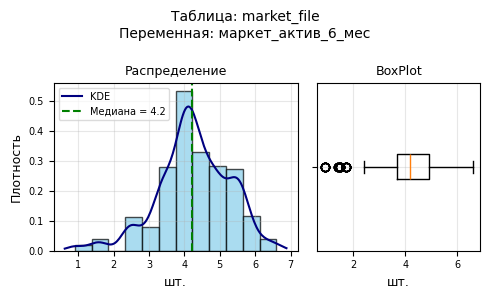

Количество уникальных значений
для переменной: 'маркет_актив_6_мес' = 41



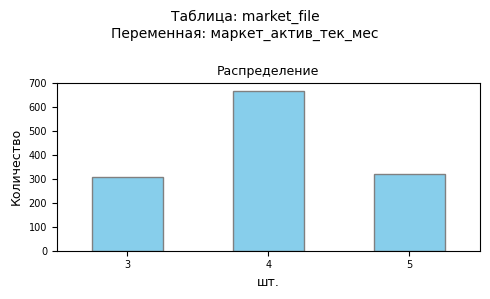

Количество уникальных значений
для переменной: 'маркет_актив_тек_мес' = 3



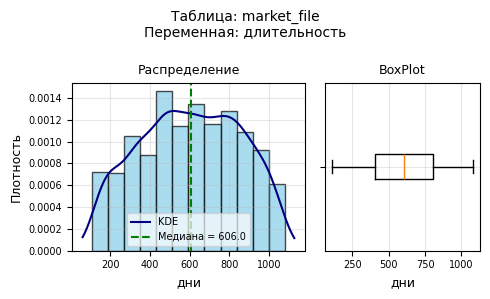

Количество уникальных значений
для переменной: 'длительность' = 658



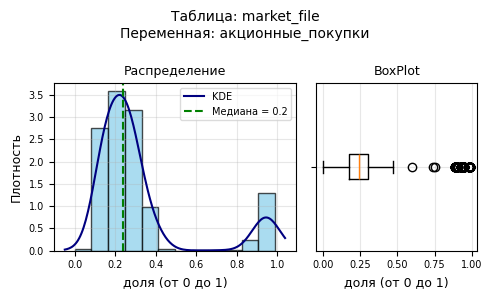

Количество уникальных значений
для переменной: 'акционные_покупки' = 42



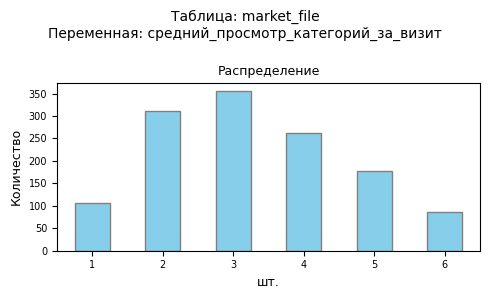

Количество уникальных значений
для переменной: 'средний_просмотр_категорий_за_визит' = 6



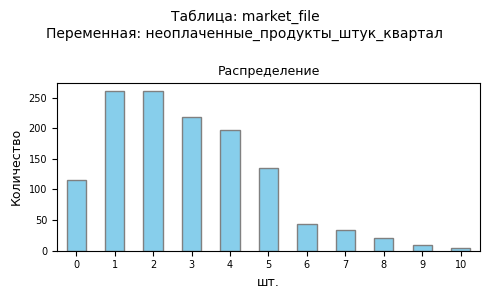

Количество уникальных значений
для переменной: 'неоплаченные_продукты_штук_квартал' = 11



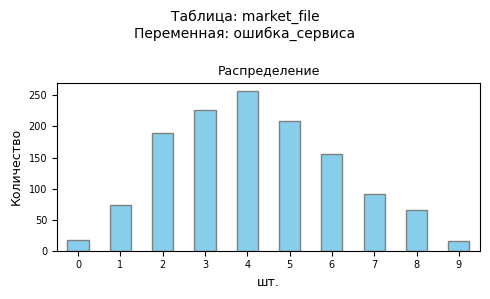

Количество уникальных значений
для переменной: 'ошибка_сервиса' = 10



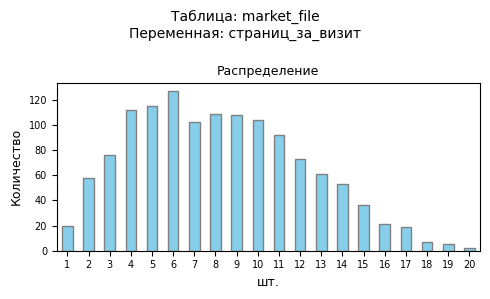

Количество уникальных значений
для переменной: 'страниц_за_визит' = 20



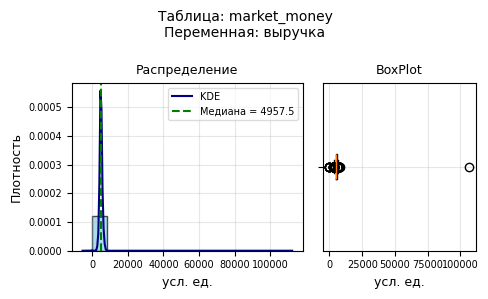

Количество уникальных значений
для переменной: 'выручка' = 2776



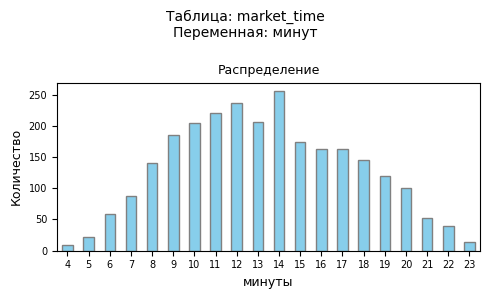

Количество уникальных значений
для переменной: 'минут' = 20



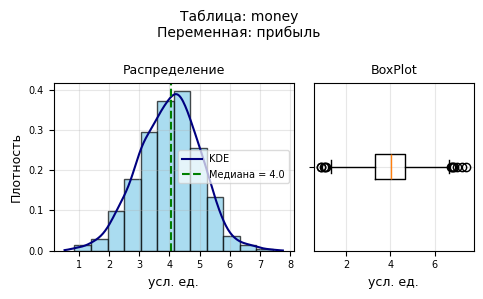

Количество уникальных значений
для переменной: 'прибыль' = 400



In [17]:
# графики по числовым переменным
display(HTML(f"<b style='color: green;'>Графики по числовым переменным</b>"))

for name_df in names_list:
    display(HTML("<div style='border-bottom: 1px solid green; margin: 10px 0;'></div>"))
    display(HTML(f"<span style='color: green;'>Таблица: {name_df}</span>"))

    # создание списка числовых полей
    num_cols = df_all[name_df].select_dtypes(include=['number']).columns.tolist()
    num_cols.remove('id')

    for col in num_cols:
        # считаем уникальные значения
        unique_vals = df_all[name_df][col].nunique(dropna=True)
        
        # графики по всем числовым полям всех датасетов
        # в зависимости от числа уникальных значений переменной
        # если число уникальных 20 и менее - строим иной график
        if unique_vals > 20:
            hist_kde_box_show (df_name=name_df,
                               df=df_all[name_df],
                               col=col,
                               units=name_units(col))
        else:
            bar_plot_with_units_show (df_name=name_df,
                                      df=df_all[name_df],
                                      col=col,
                                      units=name_units(col))        
        print(f"Количество уникальных значений\nдля переменной: '{col}' = {unique_vals}\n")

Переменная `выручка` в таблице `market_money` имеет единичный "выброс", значение которого на 2 порядка выше основной массы значений переменной. Заменим эту единичную аномалию медианным значением переменной (замена единичного значения не повлияет на результаты исследования).

In [18]:
# замена единичного "выброса" и повторный график для переменной
idx = df_all['market_money']['выручка'].idxmax()
df_all['market_money'].loc[idx, 'выручка'] = df_all['market_money']['выручка'].median()

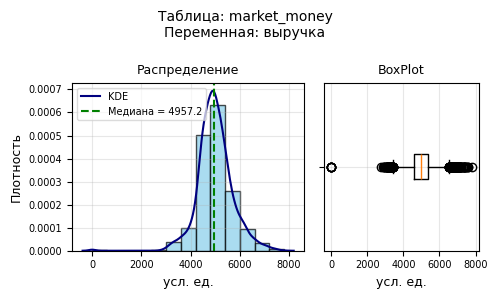

In [19]:
# повторный график по по переменной
hist_kde_box_show (df_name='market_money',
                   df=df_all['market_money'],
                   col='выручка',
                   units=name_units(col))

Нулевые значения по переменной выше не являются "выбросами", а отражают клиентов без покупок в один из месяцев.

Переменная `акционные покупки` в таблице `market_file` имеет два выраженных кластера: большой и малый процент акционных покупок.

## Категориальные признаки/переменные

Для каждого категориального показателя во всех таблицах сделаем следующее:

- выведем описательную статистику по переменной;
- построим диаграммы:
  - круговая диаграмма с процентами.

In [20]:
# описательная статистика по категориальным переменным
display(HTML(f"<b style='color: green;'>Описательная статистика по категориальным переменным</b>"))

for name_df in names_list:
    display(HTML("<div style='border-bottom: 1px solid green; margin: 10px 0;'></div>"))
    display(HTML(f"<span style='color: green;'>Таблица: {name_df}</span>"))

    # создание списка категориальных полей
    cat_cols = df_all[name_df].select_dtypes(exclude=['number']).columns.tolist()

    # описательная статистика по категориальным полям
    if cat_cols:
        display(df_all[name_df][cat_cols].describe())
    else:
        print(f"Нет категориальных полей в таблице: {name_df}")

покупательская_активность тип_сервиса разрешить_сообщать  \
count                       1300        1300               1300   
unique                         2           2                  2   
top              Прежний уровень    стандарт                 да   
freq                         802         924                962   

       популярная_категория  
count                  1300  
unique                    6  
top        Товары для детей  
freq                    330

период
count                  3900
unique                    3
top     препредыдущий_месяц
freq                   1300

период
count            2600
unique              2
top     текущий_месяц
freq             1300

Нет категориальных полей в таблице: money


In [21]:
# функция для создания диаграмм
def create_piechart (ser, ser_name):
    # Данные для графика - общие
    x = ser.value_counts().index.tolist()
    y = ser.value_counts().values.tolist()
    # создание объекта Figure
    plt.figure(figsize=(6, 3))
    plt.pie(y, labels=x, autopct='%1.1f%%')
    plt.title(ser_name)
    plt.show()

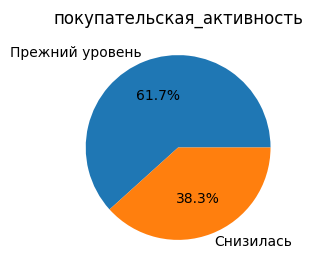

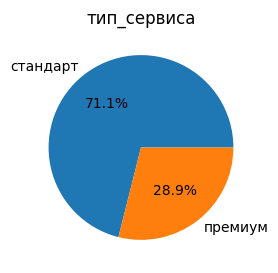

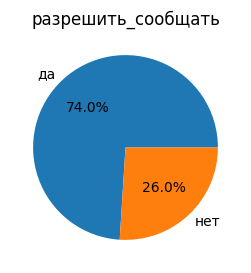

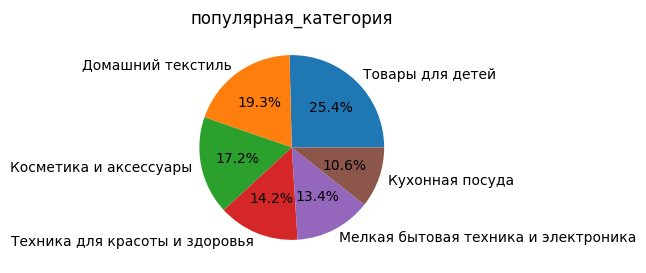

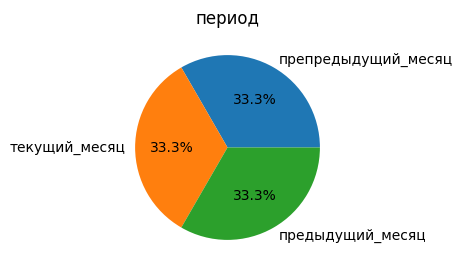

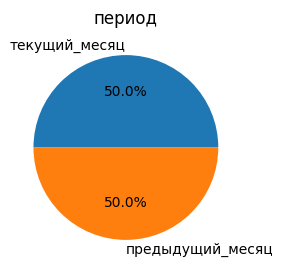

Нет категориальных полей в таблице: money


In [22]:
# диаграммы по категориальным переменным
display(HTML(f"<b style='color: green;'>Диаграммы по категориальным переменным</b>"))

for name_df in names_list:
    display(HTML("<div style='border-bottom: 1px solid green; margin: 10px 0;'></div>"))
    display(HTML(f"<span style='color: green;'>Таблица: {name_df}</span>"))

    # создание списка категориальных полей
    cat_cols = df_all[name_df].select_dtypes(exclude=['number']).columns.tolist()

    # описательная статистика по категориальным полям
    if cat_cols:
        for col in cat_cols:
            create_piechart(ser=df_all[name_df][col], ser_name=col)
    else:
        print(f"Нет категориальных полей в таблице: {name_df}")

**Промежуточные выводы**
- Аномалий в распределении категориальных признаков не выявлено.
- Следует отметить, что значения целевого признака - `покупательская_активность` - распределены неравномерно (примерно 62%/38%). В дальнейшем, при разбиении данных на обучающую/тестовую выборки, нужно применять стратификацию по этому признаку. Также это повлияет на выбор метрики оценки качества для различных моделей.

## Выводы - исследовательский анализ данных

**На этапе исследовательского анализа данных было выполнено следующее**

---
1. Обработаны "выбросы" в данных:
- Переменная `выручка` в таблице `market_money`:
  - имеет единичный "выброс", значение которого на 2 порядка выше основной массы значений переменной;
  - заменено медианным значением переменной (замена единичного значения не повлияет на результаты исследования).

---
2. Переменная `акционные покупки` в таблице `market_file`:
- имеет два выраженных кластера: большой и малый процент акционных покупок.

---
3. Категориальные столбцы:
- данные без явных аномалий;
- значения целевого признака - `покупательская_активность`:
  - распределены неравномерно (примерно 62%/38%);
  - в дальнейшем, при разбиении данных на обучающую/тестовую выборки, нужно применять стратификацию по этому признаку.

<h1 id="ref_6">Подготовка общей таблицы с данными</h1>

## Объединение таблиц

Объединение таблиц `market_file`, `market_money`, `market_time` производится с учетом следующих особенностей:

- данные таблицы `market_money` разделяются по уникальным значениям в столбце `Период`;
- данные таблицы `market_time` разделяются по уникальным значениям в столбце `Период`;
- к данным из таблицы `market_file` добавляются данные из таблиц `market_money` и `market_time` (по общему `id`), при этом данные кажого периода (из таблиц `market_money` и `market_time`) добавляются как отдельные столбцы в общую таблицу.

In [23]:
# функция создания pivot-таблиц и смена названий столбцов
# вывод на экран итогов
def create_pivot_tab (df, col, val):
    column_mapping = {period: f"{val}_{period}" for period in df['период'].unique()}
    pivoted_df = df.pivot(index='id', columns=col, values=val)
    pivoted_df = pivoted_df.rename(columns=column_mapping)
    pivoted_df = pivoted_df.reset_index()
    df_data_first_view(pivoted_df,
                       head_tail=False,
                       duplicates=False,
                       summary=True)
    return pivoted_df

In [24]:
# преоьразование таблиц
display(HTML(f"<b style='color: green;'>Объединение данных в таблицах</b>"))

# преобразование таблицы market_money
display(HTML("<div style='border-bottom: 1px solid green; margin: 10px 0;'></div>"))
display(HTML(f"<span style='color: green;'>Преобразованная таблица: market_money</span>"))

pivot_money = create_pivot_tab (df_all['market_money'], 'период', 'выручка')

# преобразование таблицы market_time
display(HTML("<div style='border-bottom: 1px solid green; margin: 10px 0;'></div>"))
display(HTML(f"<span style='color: green;'>Преобразованная таблица: market_time</span>"))

pivot_time = create_pivot_tab (df_all['market_time'], 'период', 'минут')

Информация о данных


column  non-null_count  missing_count  unique_count  \
0                           id            1300              0          1300   
1     выручка_предыдущий_месяц            1300              0          1122   
2  выручка_препредыдущий_месяц            1300              0           790   
3        выручка_текущий_месяц            1300              0          1242   

  data_type  
0     int64  
1   float64  
2   float64  
3   float64

Информация о данных


column  non-null_count  missing_count  unique_count  \
0                      id            1300              0          1300   
1  минут_предыдущий_месяц            1300              0            19   
2     минут_текущий_месяц            1300              0            20   

  data_type  
0     int64  
1     int64  
2     int64

In [25]:
# объединение таблиц
table_all_data = df_all['market_file'].merge(pivot_money, on='id', how='left').merge(pivot_time, on='id', how='left')
 
df_data_first_view(table_all_data,
                   head_tail=False,
                   duplicates=False,
                   summary=True)

Информация о данных


column  non-null_count  missing_count  \
0                                    id            1300              0   
1             покупательская_активность            1300              0   
2                           тип_сервиса            1300              0   
3                    разрешить_сообщать            1300              0   
4                    маркет_актив_6_мес            1300              0   
5                  маркет_актив_тек_мес            1300              0   
6                          длительность            1300              0   
7                     акционные_покупки            1300              0   
8                  популярная_категория            1300              0   
9   средний_просмотр_категорий_за_визит            1300              0   
10   неоплаченные_продукты_штук_квартал            1300              0   
11                       ошибка_сервиса            1300              0   
12                     страниц_за_визит            1300              0   
13             выручка_предыдущий_месяц            1300              0   
14          выручка_препредыдущий_месяц            1300              0   
15                выручка_текущий_месяц            1300              0   
16               минут_предыдущий_месяц            1300              0   
17                  минут_текущий_месяц            1300              0   

    unique_count data_type  
0           1300     int64  
1              2    object  
2              2    object  
3              2    object  
4             41   float64  
5              3     int64  
6            658     int64  
7             42   float64  
8              6    object  
9              6     int64  
10            11     int64  
11            10     int64  
12            20     int64  
13          1122   float64  
14           790   float64  
15          1242   float64  
16            19     int64  
17            20     int64

Таблицы объединены, выручка и время посещения сайта - разделены по периодам.

## Отбор клиентов

Для дальнейшего анализа отберем клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период.

In [26]:
# условия отбора и отбор клиентов - без активности
cols = ['выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц']
cond_exclude_clients = (table_all_data[cols].sum(axis=1) == 0)
display(table_all_data[cond_exclude_clients])

id покупательская_активность тип_сервиса разрешить_сообщать  \
0   215348                 Снизилась     премиум                 да   
9   215357                 Снизилась    стандарт                 да   
11  215359                 Снизилась    стандарт                 да   

    маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
0                3.400                     5           121              0.000   
9                3.900                     5           154              0.000   
11               4.600                     5           110              0.000   

              популярная_категория  средний_просмотр_категорий_за_визит  \
0                 Товары для детей                                    6   
9   Техника для красоты и здоровья                                    3   
11               Домашний текстиль                                    4   

    неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
0                                    2               1                 5   
9                                    3               9                 5   
11                                   2               4                 2   

    выручка_предыдущий_месяц  выручка_препредыдущий_месяц  \
0                      0.000                        0.000   
9                      0.000                        0.000   
11                     0.000                        0.000   

    выручка_текущий_месяц  минут_предыдущий_месяц  минут_текущий_месяц  
0               3,293.100                      13                   14  
9               5,986.300                      12                    6  
11              4,735.000                      13                   11

In [27]:
# отбор клиентов - с активностью
table_all_data = table_all_data[~(cond_exclude_clients)].reset_index(drop=True)
print(table_all_data.shape)
table_all_data_copy = table_all_data.copy()

(1297, 18)


## Ввод новых переменных

---
1. Переменные отражающие динамику выручки по месяцам:
- новая переменная: `выручка_0_1`: разница в выручке текущего и предыдущего месяцев;
- новая переменная: `выручка_1_2`: разница в выручке предыдущего и предпредыдущего месяцев;
- новая переменная: `выручка_0_2`: разница в выручке текущего и предпредыдущего месяцев.
 
---
2. Переменная отражающая динамику времени, проведённого на сайте по месяцам:
- новая переменная: `минут_0_1`: разница в минутах текущего и предыдущего месяцев.

---
3. Переменная отражающая динамику количества маркетинговых коммуникаций в текущем месяце относительно среднего за предыдущие 6 мес.:
- новая переменная: `маркет_актив_0_6мес`: разница в количестве маркетинговых коммуникаций текущего месяца и среднего значения за 6 месяцев.

In [28]:
# новая переменная - 1
table_all_data['выручка_0_1'] = (table_all_data['выручка_текущий_месяц']\
                                 - table_all_data['выручка_предыдущий_месяц'])\
    .astype('float64')

# новая переменная - 2
table_all_data['выручка_0_2'] = (table_all_data['выручка_текущий_месяц']\
                                 - table_all_data['выручка_препредыдущий_месяц'])\
    .astype('float64')

# новая переменная - 3
table_all_data['выручка_1_2'] = (table_all_data['выручка_предыдущий_месяц']\
                                 - table_all_data['выручка_препредыдущий_месяц'])\
    .astype('float64')

# новая переменная - 4
table_all_data['минут_0_1'] = (table_all_data['минут_текущий_месяц']\
                                - table_all_data['минут_предыдущий_месяц'])\
    .astype('float64')

# новая переменная - 5
table_all_data['маркет_актив_0_6м'] = (table_all_data['маркет_актив_тек_мес']\
                                            - table_all_data['маркет_актив_6_мес']).\
    astype('float64')

# изменяем тип всех object столбцов на category
table_all_data = table_all_data.astype(
    {col: 'category' for col in table_all_data.select_dtypes(include='object').columns})

# контроль изменений в таблице
df_data_first_view(table_all_data,
                   head_tail=True,
                   duplicates=False,
                   summary=True)

Первые 3 и последние 3 строк датасета


id покупательская_активность тип_сервиса разрешить_сообщать  \
0     215349                 Снизилась     премиум                 да   
1     215350                 Снизилась    стандарт                нет   
2     215351                 Снизилась    стандарт                 да   
1294  216645           Прежний уровень    стандарт                 да   
1295  216646           Прежний уровень    стандарт                 да   
1296  216647           Прежний уровень     премиум                 да   

      маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
0                  4.400                     4           819   
1                  4.900                     3           539   
2                  3.200                     5           896   
1294               4.100                     3           586   
1295               6.300                     5           645   
1296               4.000                     5           906   

      акционные_покупки            популярная_категория  \
0                 0.750                Товары для детей   
1                 0.140               Домашний текстиль   
2                 0.990                Товары для детей   
1294              0.200               Домашний текстиль   
1295              0.120  Техника для красоты и здоровья   
1296              0.940  Техника для красоты и здоровья   

      средний_просмотр_категорий_за_визит  ...  выручка_предыдущий_месяц  \
0                                       4  ...                 5,216.000   
1                                       5  ...                 5,457.500   
2                                       5  ...                 6,158.000   
1294                                    3  ...                 5,160.000   
1295                                    3  ...                 4,923.000   
1296                                    4  ...                 4,720.000   

      выручка_препредыдущий_месяц  выручка_текущий_месяц  \
0                       4,472.000              4,971.600   
1                       4,826.000              5,058.400   
2                       4,793.000              6,610.400   
1294                    5,334.000              5,139.200   
1295                    4,725.000              5,224.600   
1296                    5,183.000              4,448.300   

      минут_предыдущий_месяц  минут_текущий_месяц  выручка_0_1  выручка_0_2  \
0                         12                   10     -244.400      499.600   
1                          8                   13     -399.100      232.400   
2                         11                   13      452.400    1,817.400   
1294                      12                   18      -20.800     -194.800   
1295                      18                    7      301.600      499.600   
1296                      15                   10     -271.700     -734.700   

      выручка_1_2  минут_0_1  маркет_актив_0_6м  
0         744.000     -2.000             -0.400  
1         631.500      5.000             -1.900  
2       1,365.000      2.000              1.800  
1294     -174.000      6.000             -1.100  
1295      198.000    -11.000             -1.300  
1296     -463.000     -5.000              1.000  

[6 rows x 23 columns]

Информация о данных


column  non-null_count  missing_count  \
0                                    id            1297              0   
1             покупательская_активность            1297              0   
2                           тип_сервиса            1297              0   
3                    разрешить_сообщать            1297              0   
4                    маркет_актив_6_мес            1297              0   
5                  маркет_актив_тек_мес            1297              0   
6                          длительность            1297              0   
7                     акционные_покупки            1297              0   
8                  популярная_категория            1297              0   
9   средний_просмотр_категорий_за_визит            1297              0   
10   неоплаченные_продукты_штук_квартал            1297              0   
11                       ошибка_сервиса            1297              0   
12                     страниц_за_визит            1297              0   
13             выручка_предыдущий_месяц            1297              0   
14          выручка_препредыдущий_месяц            1297              0   
15                выручка_текущий_месяц            1297              0   
16               минут_предыдущий_месяц            1297              0   
17                  минут_текущий_месяц            1297              0   
18                          выручка_0_1            1297              0   
19                          выручка_0_2            1297              0   
20                          выручка_1_2            1297              0   
21                            минут_0_1            1297              0   
22                    маркет_актив_0_6м            1297              0   

    unique_count data_type  
0           1297     int64  
1              2  category  
2              2  category  
3              2  category  
4             41   float64  
5              3     int64  
6            657     int64  
7             41   float64  
8              6  category  
9              6     int64  
10            11     int64  
11            10     int64  
12            20     int64  
13          1121   float64  
14           789   float64  
15          1239   float64  
16            19     int64  
17            20     int64  
18           837   float64  
19          1132   float64  
20           967   float64  
21            30   float64  
22            70   float64

<h1 id="ref_7">Корреляционный анализ</h1>

## Вспомогательные функции для анализа корреляций

In [29]:
# функция вывода матрицы - тепловая карта
def heatmap_show(df, graph_title, figsize=(10, 8), font_size=8):
    plt.figure(figsize=figsize)
    sns.heatmap(
        df,
        annot=True,
        cmap='RdYlGn_r',
        fmt='.2f',
        linewidths=0.5,
        annot_kws={"size": font_size},
        cbar_kws={"shrink": 0.8}
    )
    plt.title(graph_title, fontsize=font_size+4)
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)
    plt.show()

# функция вывода Scatter Matrix
def scatter_matrix_num_show (df, graph_title):
    g = sns.PairGrid(df)
    g.map_upper(sns.scatterplot, color='blue')
    g.map_lower(sns.scatterplot, color='blue')
    g.map_diag(sns.histplot, color='green', alpha=0.7)
    plt.suptitle(graph_title, y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()

# функция вывода Scatter Matrix и гистограмм
# с разделением по категориальному признаку
def scatter_matrix_num_by_cat_subplots(df,
                                       name_cols_for_view,
                                       cat_name,
                                       cat_title,
                                       plots_per_fig=16,
                                       main_title=None):
    """
    Функция строит все возможные пары признаков в виде отдельных subplot'ов.
    Каждая пара: (x, y) — scatter plot с разделением по cat_name.
    Затем отдельно выводятся гистограммы для каждого признака с разделением по cat_name.
    """
    pairs = list(combinations(name_cols_for_view, 2))
    n_pairs = len(pairs)

    histograms = name_cols_for_view
    n_hists = len(histograms)

    print(f"Всего пар признаков: {n_pairs}")
    print(f"Всего гистограмм: {n_hists}")

    # Получаем все уникальные значения целевой переменной
    unique_categories = df[cat_name].dropna().unique()
    palette = sns.color_palette('Set1', len(unique_categories))
    color_map = dict(zip(unique_categories, palette))

    # === рисуем scatter plot'ы ===
    all_pair_items = [('pair', pair) for pair in pairs]
    n_pair_items = len(all_pair_items)

    idx = 0
    while idx < n_pair_items:
        fig, axes = plt.subplots(4, 4, figsize=(16, 16))
        axes = axes.flatten()
        for i in range(len(axes)):
            if idx < n_pair_items:
                item_type, item_data = all_pair_items[idx]
                if item_type == 'pair':
                    x_col, y_col = item_data
                    sns.scatterplot(data=df, x=x_col, y=y_col, hue=cat_name, palette=color_map, ax=axes[i], alpha=0.5)
                    axes[i].set_title(f'{x_col}\nvs\n{y_col}')
                axes[i].legend([],[], frameon=False)  # Убираем легенду в subplot
            else:
                axes[i].axis('off')
            idx += 1

        # Добавляем общий заголовок
        if main_title:
            fig.suptitle(main_title + '\n(Scatter Plots)', fontsize=16, y=1.05)

        # Создаём искусственную легенду с использованием всех категорий
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[cat], markersize=10) for cat in unique_categories]
        labels = [str(cat) for cat in unique_categories]

        # Добавляем общую легенду
        fig.legend(handles, labels, title=cat_title, bbox_to_anchor=(0, 1), loc='lower left')

        plt.tight_layout()
        plt.subplots_adjust(top=0.95)
        plt.show()

    # === рисуем гистограммы ===
    all_hist_items = [('hist', col) for col in histograms]
    n_hist_items = len(all_hist_items)

    idx = 0
    while idx < n_hist_items:
        fig, axes = plt.subplots(4, 4, figsize=(16, 16))
        axes = axes.flatten()
        for i in range(len(axes)):
            if idx < n_hist_items:
                item_type, item_data = all_hist_items[idx]
                if item_type == 'hist':
                    col = item_data
                    sns.histplot(data=df, x=col, hue=cat_name, palette=color_map, ax=axes[i], alpha=0.5)
                    axes[i].set_title(f'Гистограмма:\n{col}')
                axes[i].legend([],[], frameon=False)  # Убираем легенду в subplot
            else:
                axes[i].axis('off')
            idx += 1

        # Добавляем общий заголовок
        if main_title:
            fig.suptitle(main_title + '\n(Histograms)', fontsize=16, y=1.05)

        # Создаём искусственную легенду с использованием всех категорий
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[cat], markersize=10) for cat in unique_categories]
        labels = [str(cat) for cat in unique_categories]

        # Добавляем общую легенду
        fig.legend(handles, labels, title=cat_title, bbox_to_anchor=(0, 1), loc='lower left')

        plt.tight_layout()
        plt.subplots_adjust(top=0.95)
        plt.show()

# функция интерпретации корреляций и p-value
def corr_interpretation (row):
    corr = row['phi_k']
    p_value = row['p_value']
    if corr < 0.2:
        dependence = 'очень слабая'
    elif corr < 0.4:
        dependence = 'слабая'
    elif corr < 0.6:
        dependence = 'умеренная'
    elif corr < 0.8:
        dependence = 'сильная'
    elif corr < 1.00:
        dependence = 'очень сильная'
    else:
        dependence = 'функциональная'
    significance = 'значимая' if p_value < 0.05 else 'не значимая'
    return dependence, significance

## Анализ корреляций (Phi_K)

In [30]:
# список числовых переменных - первичный анализ
num_cols = table_all_data.select_dtypes(include=['number']).columns.tolist()
if 'id' in num_cols:
    num_cols.remove('id')

# фомрируем переменные, в которых у нас 20 и менее уникальных значений
not_num_cols = [col for col in num_cols if table_all_data[col].nunique() <= 20]

# формируем финальный список числовых переменных
num_cols = [col for col in num_cols if table_all_data[col].nunique() > 20]

print('Числовые переменные:\n', num_cols)

# список категориальных переменных для первичного анализа
cat_cols = table_all_data.select_dtypes(exclude=['number']).columns.tolist()

# формируем фыинальный список категориальных переменных
cat_cols = cat_cols + not_num_cols

print('Категориальные переменные:\n', cat_cols)

Числовые переменные:
 ['маркет_актив_6_мес', 'длительность', 'акционные_покупки', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 'выручка_0_1', 'выручка_0_2', 'выручка_1_2', 'минут_0_1', 'маркет_актив_0_6м']
Категориальные переменные:
 ['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'популярная_категория', 'маркет_актив_тек_мес', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'минут_предыдущий_месяц', 'минут_текущий_месяц']


In [31]:
# создание матрицы корреляций для первичного анализа
all_cols = cat_cols + num_cols
df_begin = table_all_data.copy()
df_begin = table_all_data[all_cols]

# создание матрицы корреляций (PhiK) для первичного анализа
phik_matrix = df_begin.phik_matrix(interval_cols = num_cols)

# создание матрицы p-value (PhiK) для первичного анализа
phik_significance = df_begin.significance_matrix(interval_cols = num_cols)
phik_p_value = 2 * (1 - stats.norm.cdf(phik_significance.abs()))
phik_p_value_matrix = pd.DataFrame(phik_p_value, index=all_cols, columns=all_cols)

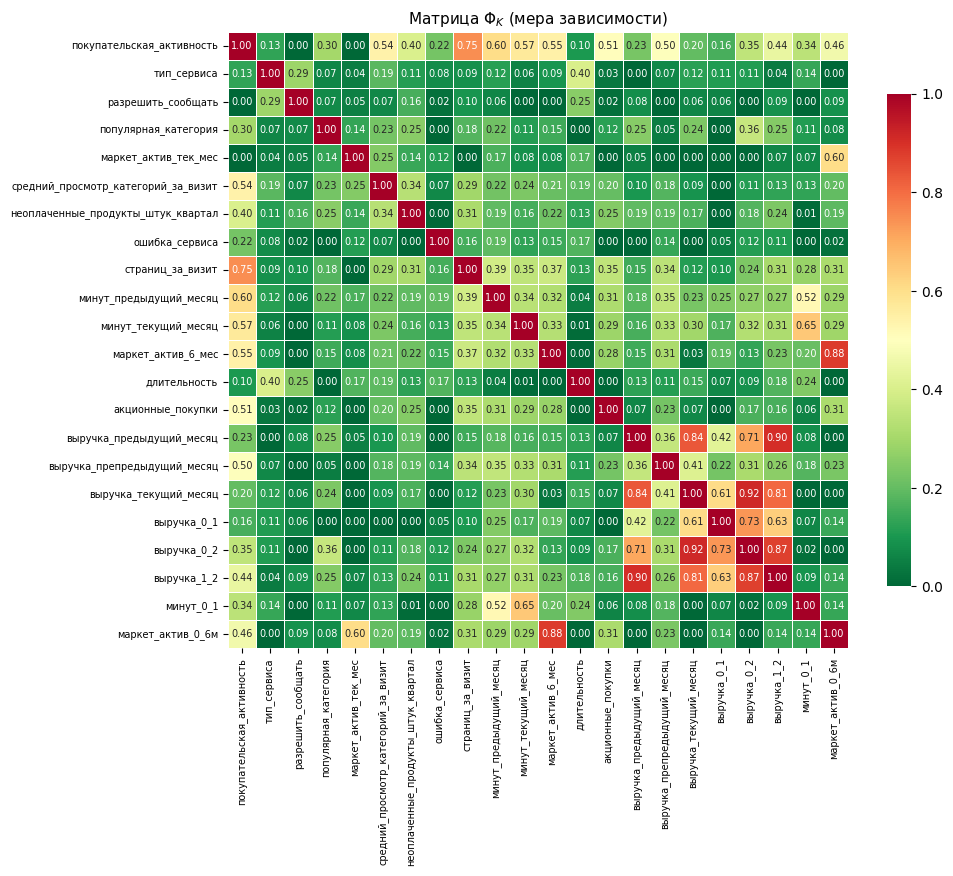

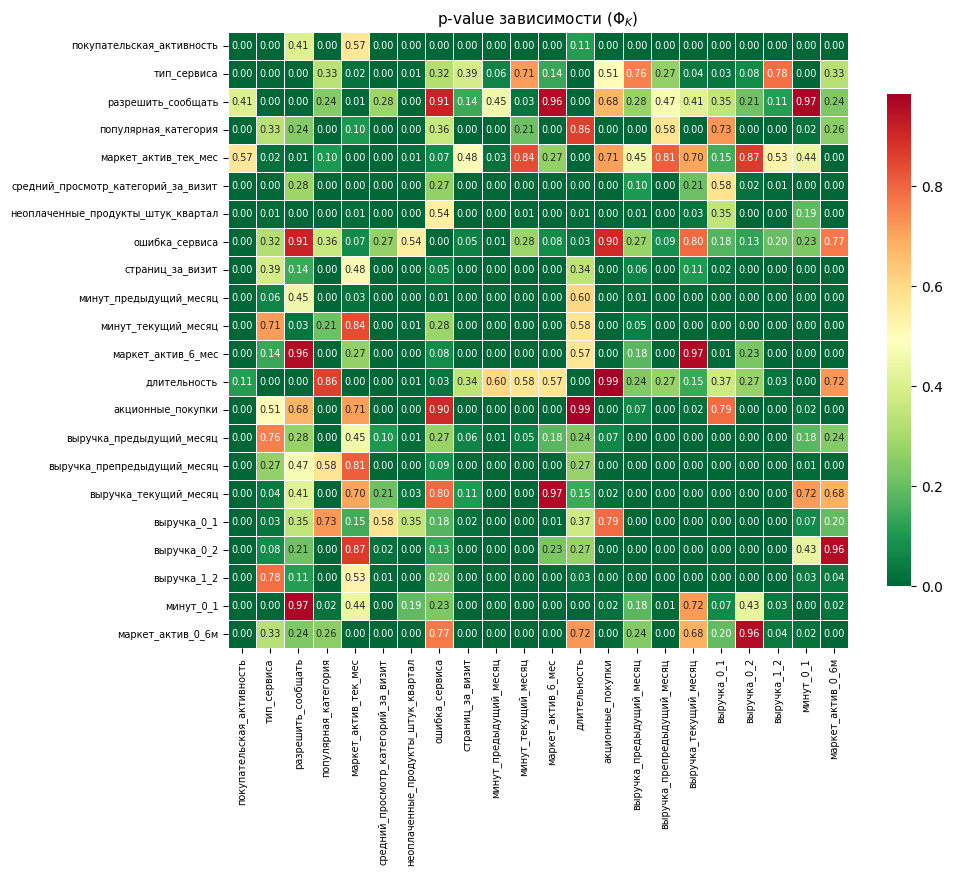

In [32]:
# тепловая карта - корреляции
heatmap_show (phik_matrix,
              r'Матрица $\Phi_K$ (мера зависимости)',
              figsize=(10, 8),
              font_size=7
             )

# тепловая карта - p-value
heatmap_show (phik_p_value_matrix,
              r'p-value зависимости ($\Phi_K$)',
              figsize=(10, 8),
              font_size=7
             )

In [33]:
# фиксация целевой переменной
target_variable = 'покупательская_активность'
exclude_rows = [target_variable]

# выборки из построенных таблиц корреляций и p-value
corr_phik_target = pd.concat([phik_matrix.loc[~phik_matrix.index.isin(exclude_rows), [target_variable]],
                                phik_p_value_matrix.loc[~phik_p_value_matrix.index.isin(exclude_rows), [target_variable]]], axis = 1)
corr_phik_target.columns = ['phi_k', 'p_value']

# вывод анализа корреляций (PhiK) для целевой переменной
corr_phik_target[['strength_of_connection', 'significance']] = \
corr_phik_target.apply(corr_interpretation, axis=1, result_type='expand')
corr_phik_target = corr_phik_target.sort_values(by='phi_k', ascending=False)

display(HTML(f"<b style='color: green;'>Корреляции целевой переменной с входными признаками</b>"))
display(corr_phik_target)

num_hi = corr_phik_target[corr_phik_target['strength_of_connection'].isin(['сильная','умеренная'])]['strength_of_connection'].count()

display(HTML(f"<span style='color: green;'>Сильные и умеренные корреляции: {num_hi} шт.</span>"))
display(HTML(f"<span style='color: green;'>Слабые и не значимые корреляции: {corr_phik_target.shape[0] - num_hi} шт.</span>"))

phi_k  p_value strength_of_connection  \
страниц_за_визит                     0.747    0.000                сильная   
минут_предыдущий_месяц               0.604    0.000                сильная   
минут_текущий_месяц                  0.569    0.000              умеренная   
маркет_актив_6_мес                   0.546    0.000              умеренная   
средний_просмотр_категорий_за_визит  0.539    0.000              умеренная   
акционные_покупки                    0.507    0.000              умеренная   
выручка_препредыдущий_месяц          0.495    0.000              умеренная   
маркет_актив_0_6м                    0.464    0.000              умеренная   
выручка_1_2                          0.442    0.000              умеренная   
неоплаченные_продукты_штук_квартал   0.404    0.000              умеренная   
выручка_0_2                          0.351    0.000                 слабая   
минут_0_1                            0.340    0.000                 слабая   
популярная_категория                 0.298    0.000                 слабая   
выручка_предыдущий_месяц             0.227    0.000                 слабая   
ошибка_сервиса                       0.224    0.000                 слабая   
выручка_текущий_месяц                0.195    0.000           очень слабая   
выручка_0_1                          0.161    0.000           очень слабая   
тип_сервиса                          0.132    0.002           очень слабая   
длительность                         0.102    0.114           очень слабая   
маркет_актив_тек_мес                 0.000    0.568           очень слабая   
разрешить_сообщать                   0.000    0.406           очень слабая   

                                    significance  
страниц_за_визит                        значимая  
минут_предыдущий_месяц                  значимая  
минут_текущий_месяц                     значимая  
маркет_актив_6_мес                      значимая  
средний_просмотр_категорий_за_визит     значимая  
акционные_покупки                       значимая  
выручка_препредыдущий_месяц             значимая  
маркет_актив_0_6м                       значимая  
выручка_1_2                             значимая  
неоплаченные_продукты_штук_квартал      значимая  
выручка_0_2                             значимая  
минут_0_1                               значимая  
популярная_категория                    значимая  
выручка_предыдущий_месяц                значимая  
ошибка_сервиса                          значимая  
выручка_текущий_месяц                   значимая  
выручка_0_1                             значимая  
тип_сервиса                             значимая  
длительность                         не значимая  
маркет_актив_тек_мес                 не значимая  
разрешить_сообщать                   не значимая

**Корреляции целевой переменной со входными признаками**:

- 10 из 21 входных признаков имеют сильные или умеренные корреляции с целевой переменной;
- 11 из 21 входных признаков имеют слабые или не значимые корреляции с целевой переменной;
- максимальная корреляция у входной переменной `страниц_за_визит` (0.75);
- ***нет переменных с корреляцией более 0.90-0.95; утечки данных не обнаружено***.

In [34]:
# Пороги для корреляций и p-value
corr_tsh = 0.4
p_value_tsh = 0.05

# Удаляем целевую переменную из обеих таблиц
phik_filtered = phik_matrix.drop(index=target_variable, columns=target_variable)
p_value_filtered = phik_p_value_matrix.drop(index=target_variable, columns=target_variable)

# Создаём маску для значимых корреляций, НЕ учитывем главную диагональ
mask_diag = ~np.eye(len(phik_filtered), dtype=bool)
mask = (phik_filtered.abs() >= corr_tsh) & (p_value_filtered < p_value_tsh) & mask_diag

# Применяем маску к обеим таблицам
phik_significant = phik_filtered.where(mask)
p_value_significant = p_value_filtered.where(mask)

# Удаляем полностью пустые строки и столбцы
phik_significant = phik_significant.dropna(axis=0, how='all').dropna(axis=1, how='all')
p_value_significant = p_value_significant.dropna(axis=0, how='all').dropna(axis=1, how='all')

# Создаём список пар признаков с высокой и значимой корреляцией
significant_pairs = []
for i in range(len(phik_significant.index)):
    for j in range(i + 1, len(phik_significant.columns)):
        row_idx = phik_significant.index[i]
        col_idx = phik_significant.columns[j]
        if mask.loc[row_idx, col_idx]:
            significant_pairs.append((row_idx, col_idx,
                                      phik_significant.loc[row_idx, col_idx],
                                      p_value_significant.loc[row_idx, col_idx]))

# Создаём DataFrame из списка
df_significant_pairs = pd.DataFrame(significant_pairs, 
                                    columns=['var_1', 'var_2', 'phi_k', 'p_value']
                                   ).sort_values(by='phi_k', ascending=False).reset_index(drop=True)

df_significant_pairs[['strength_of_connection', 'significance']] = \
df_significant_pairs.apply(corr_interpretation, axis=1, result_type='expand')

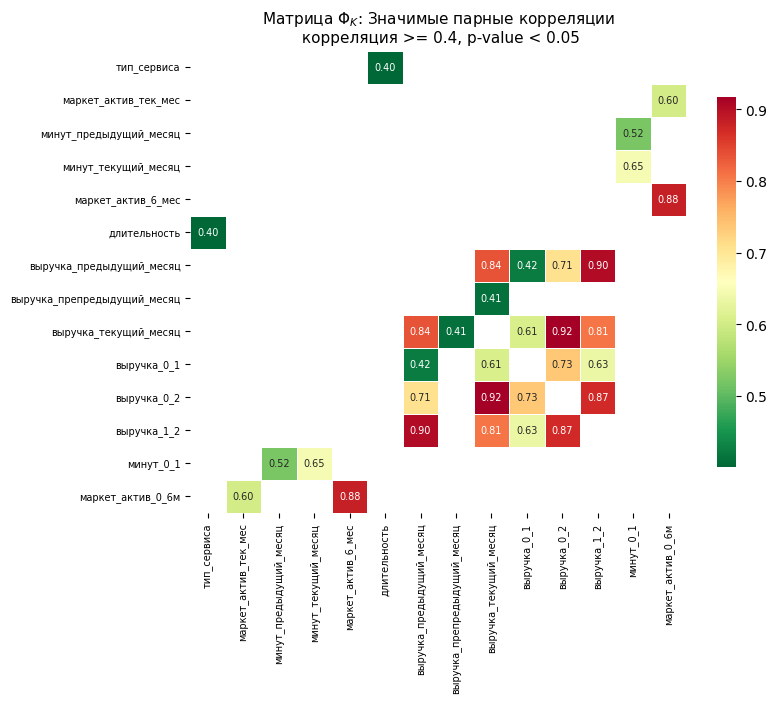

var_1                  var_2  phi_k  p_value  \
0         выручка_текущий_месяц            выручка_0_2  0.917    0.000   
1      выручка_предыдущий_месяц            выручка_1_2  0.904    0.000   
2            маркет_актив_6_мес      маркет_актив_0_6м  0.882    0.000   
3                   выручка_0_2            выручка_1_2  0.872    0.000   
4      выручка_предыдущий_месяц  выручка_текущий_месяц  0.836    0.000   
5         выручка_текущий_месяц            выручка_1_2  0.808    0.000   
6                   выручка_0_1            выручка_0_2  0.735    0.000   
7      выручка_предыдущий_месяц            выручка_0_2  0.707    0.000   
8           минут_текущий_месяц              минут_0_1  0.646    0.000   
9                   выручка_0_1            выручка_1_2  0.635    0.000   
10        выручка_текущий_месяц            выручка_0_1  0.607    0.000   
11         маркет_актив_тек_мес      маркет_актив_0_6м  0.603    0.000   
12       минут_предыдущий_месяц              минут_0_1  0.522    0.000   
13     выручка_предыдущий_месяц            выручка_0_1  0.422    0.000   
14  выручка_препредыдущий_месяц  выручка_текущий_месяц  0.411    0.000   
15                  тип_сервиса           длительность  0.401    0.000   

   strength_of_connection significance  
0           очень сильная     значимая  
1           очень сильная     значимая  
2           очень сильная     значимая  
3           очень сильная     значимая  
4           очень сильная     значимая  
5           очень сильная     значимая  
6                 сильная     значимая  
7                 сильная     значимая  
8                 сильная     значимая  
9                 сильная     значимая  
10                сильная     значимая  
11                сильная     значимая  
12              умеренная     значимая  
13              умеренная     значимая  
14              умеренная     значимая  
15              умеренная     значимая

In [35]:
# тепловая карта - значимые корреляции входных признаков
heatmap_show (phik_significant,
              f"Матрица $\Phi_K$: Значимые парные корреляции\n корреляция >= {corr_tsh}, p-value < {p_value_tsh}",
              figsize=(8, 6),
              font_size=7
             )

# Таблица - входные признаки со значимыми парными корреляциями
display(HTML(f"<b style='color: green;'>Входные признаки со значимыми парными корреляциями</b>"))
display(df_significant_pairs)

**Входные признаки со значимыми парными корреляциями** (как видно из таблицы/диаграммы выше):

---
1. Были введены новые входные признаки, которые были образованы как разность (т.е. по сути линейная комбинация) исходных признаков. Прямое следствие этого:
- присутствуют сильные парные корреляции новых признаков с исходными по группам:
  - выручка/динамика выручки;
  - время на сайте/динамика времени на сайте;
  - маркетинговые коммуникации/динамика маркетинговых коммуникаций;
- в каждой из перечисленных групп признаков нужно оставить один или два (если возможно).

---
2. Есть также умеренные парные корреляции еще по некоторым парам входных признаков:
- тип_сервиса vs длительность.

---
3. Прочие парные корреляции входных признаков слабые или не значимые.

## Анализ диаграмм рассеяния

Всего пар признаков: 55
Всего гистограмм: 11


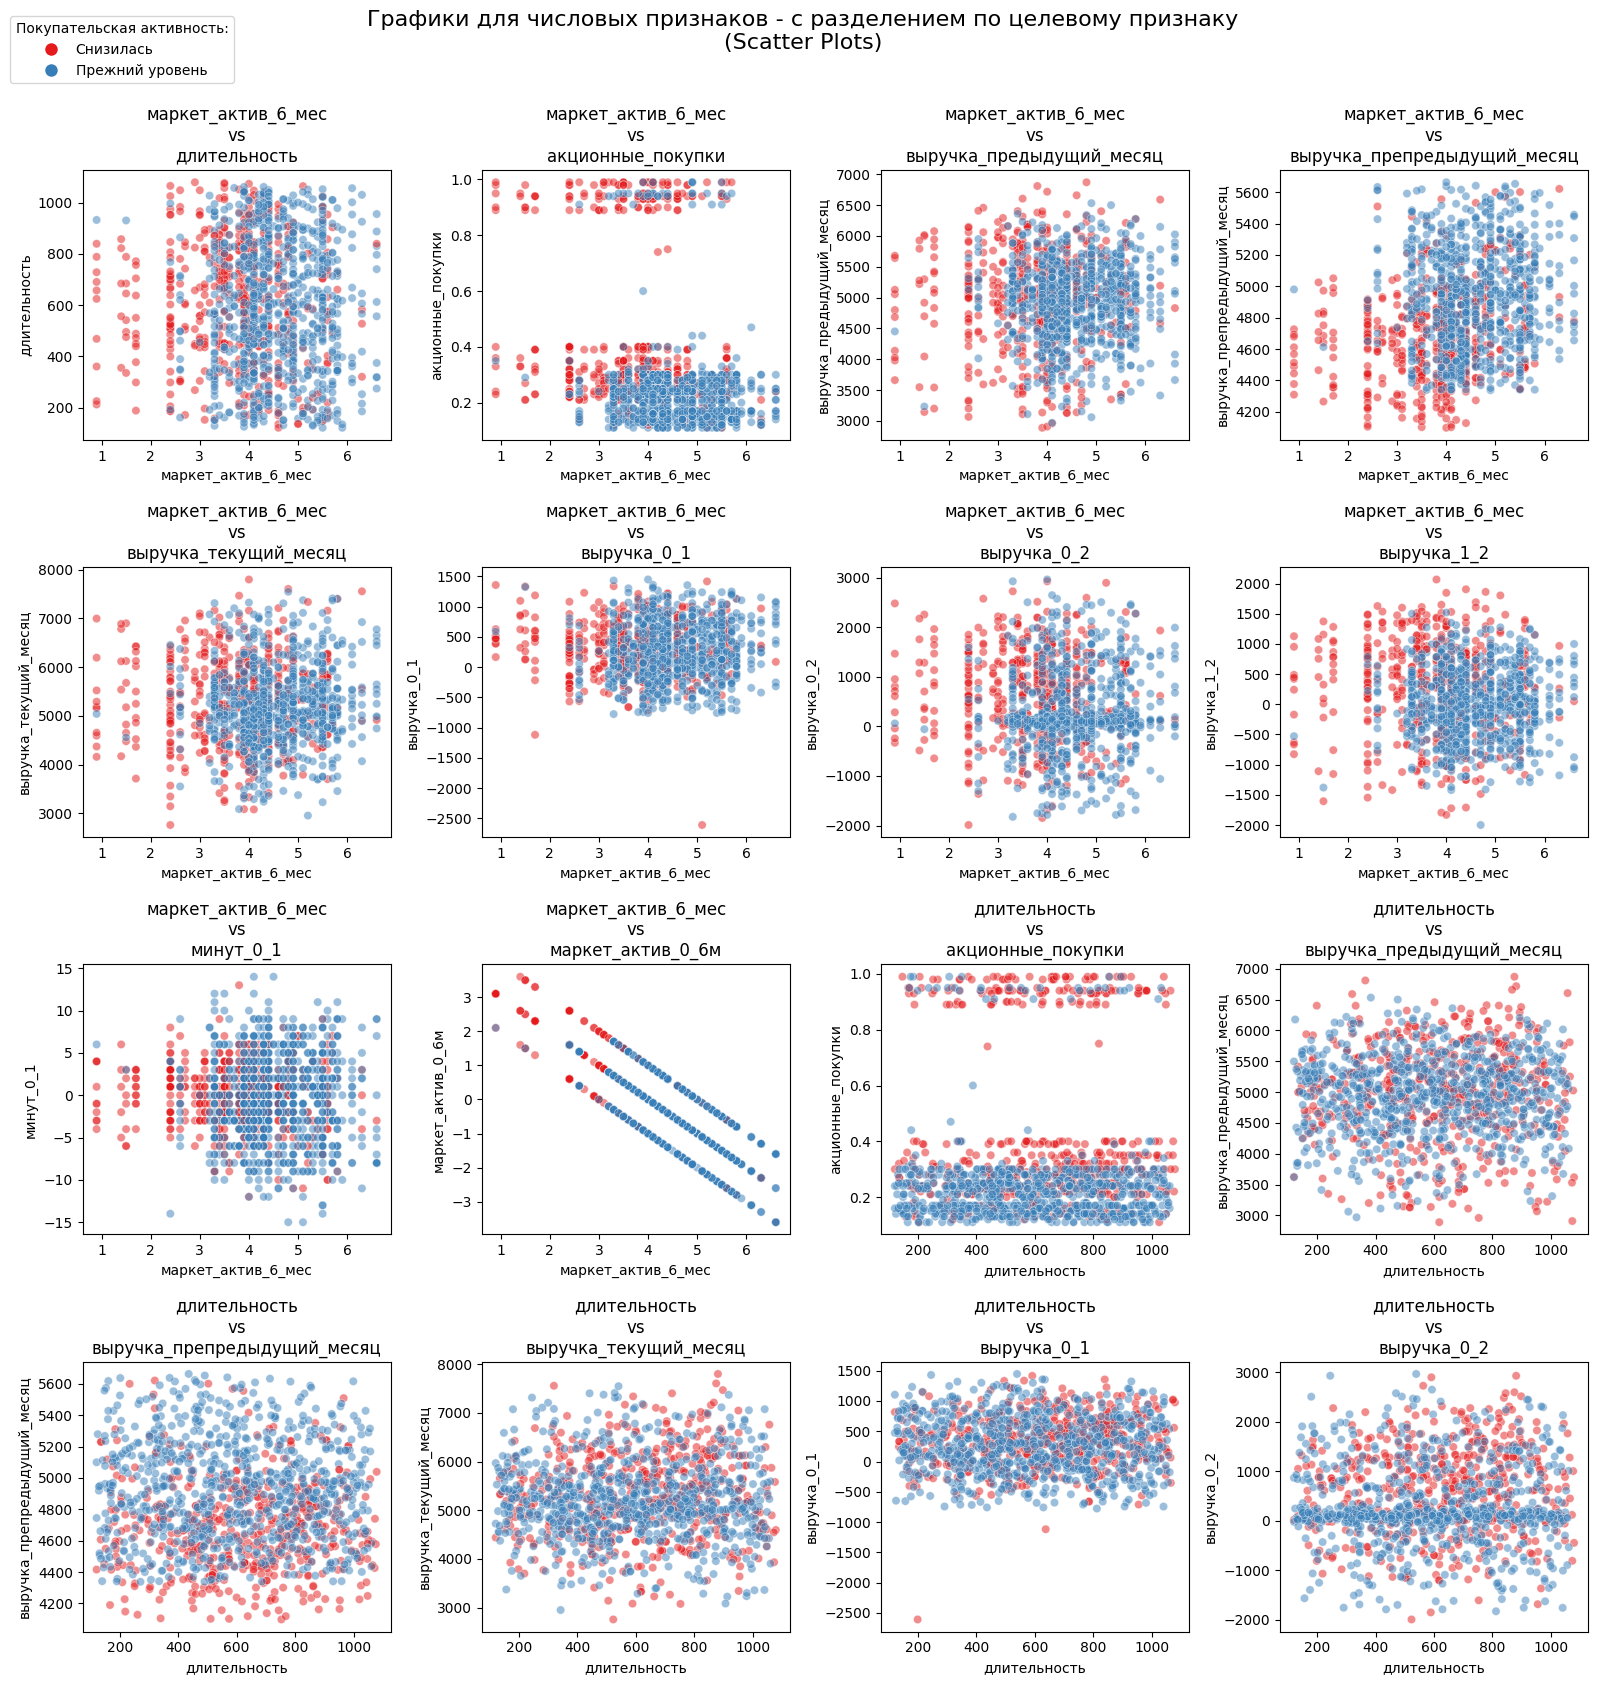

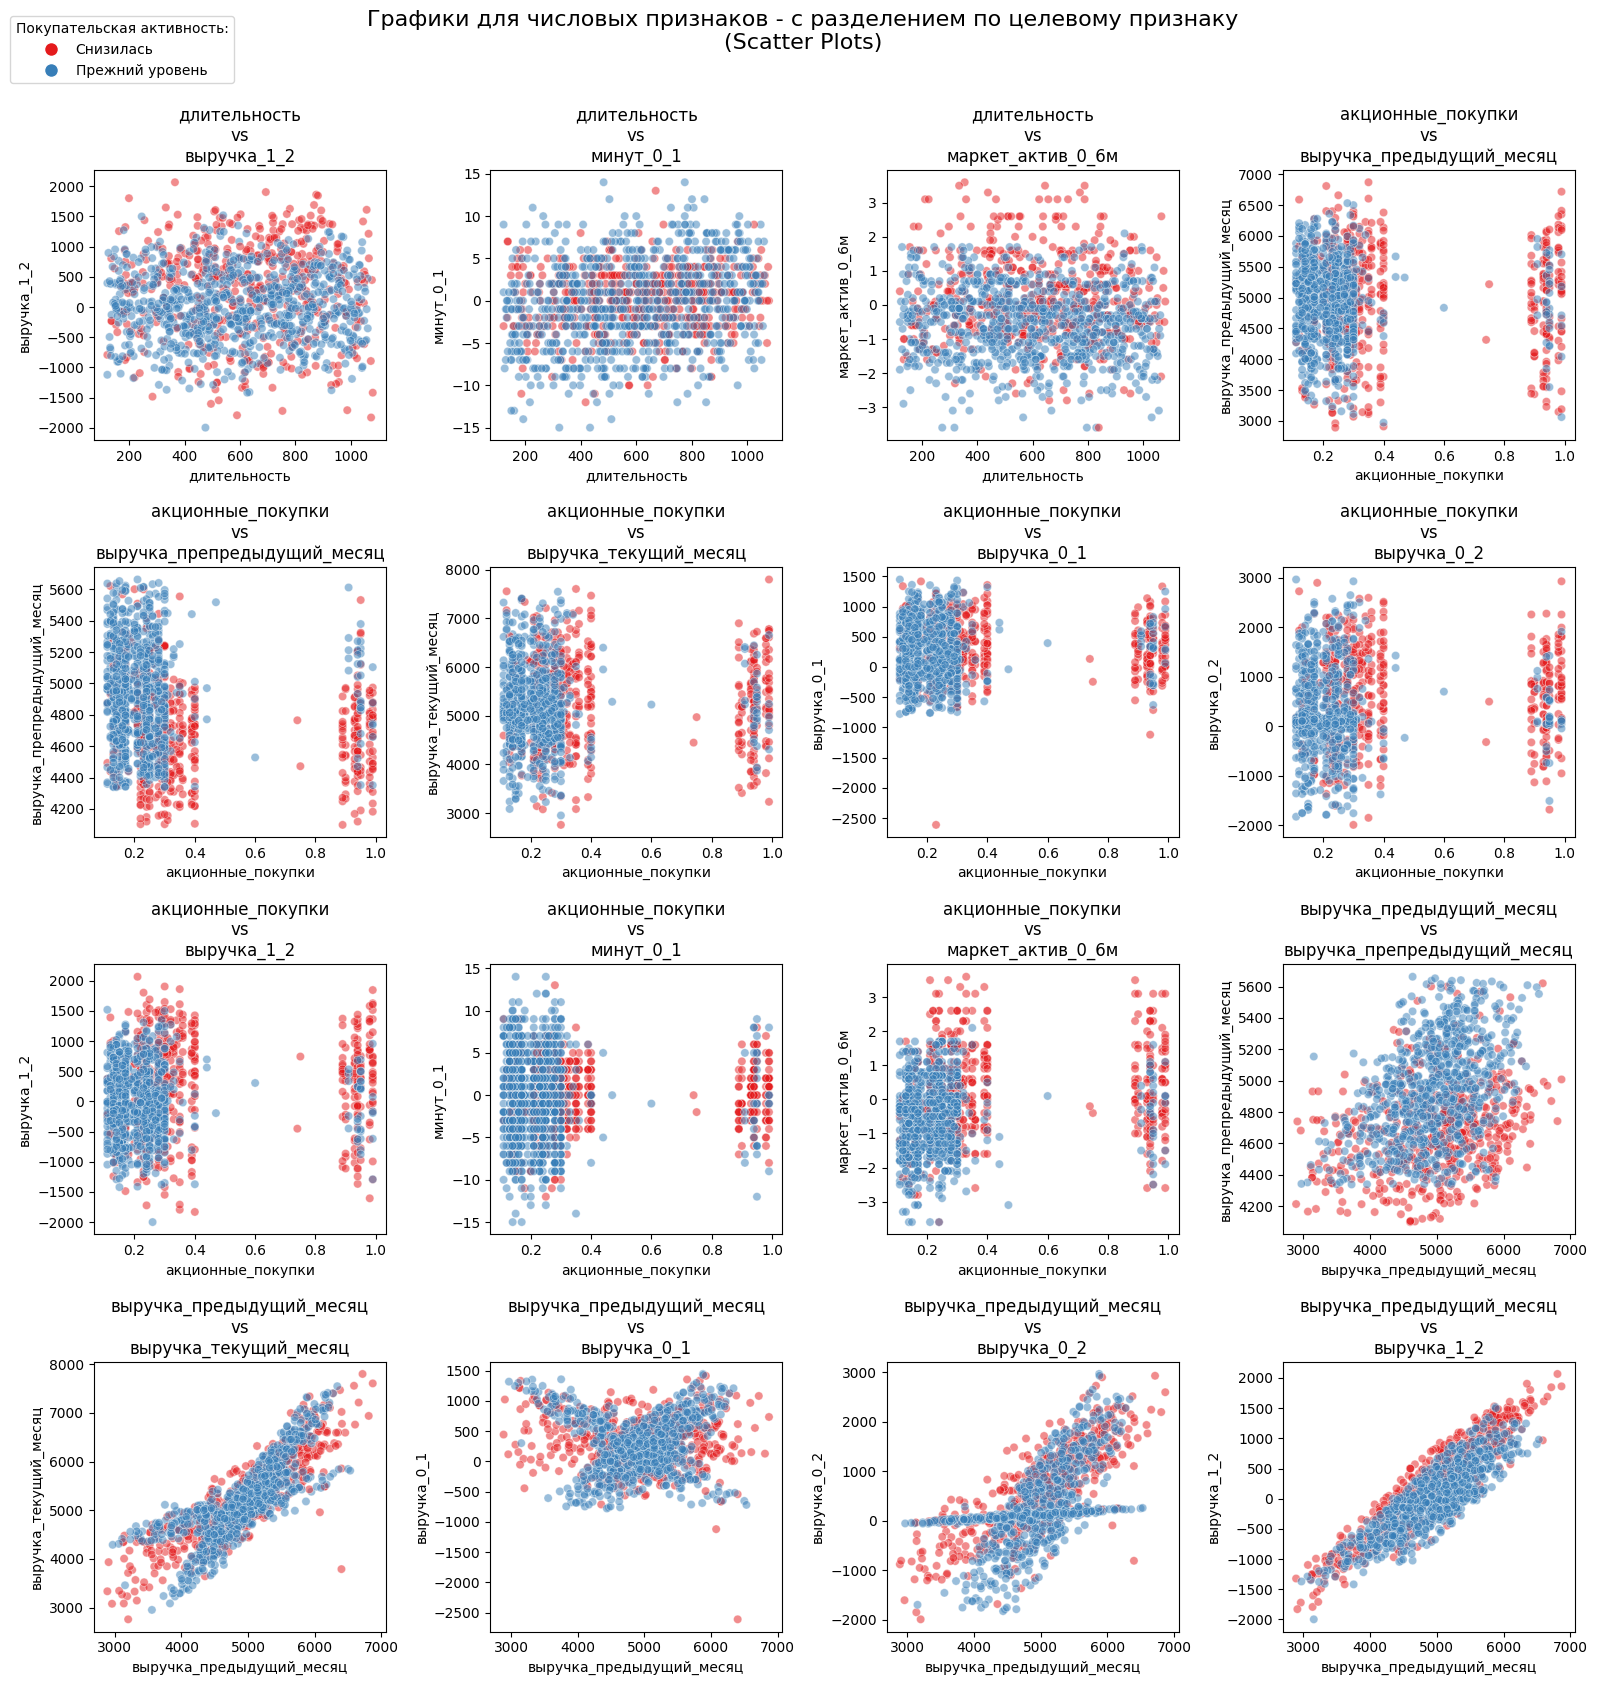

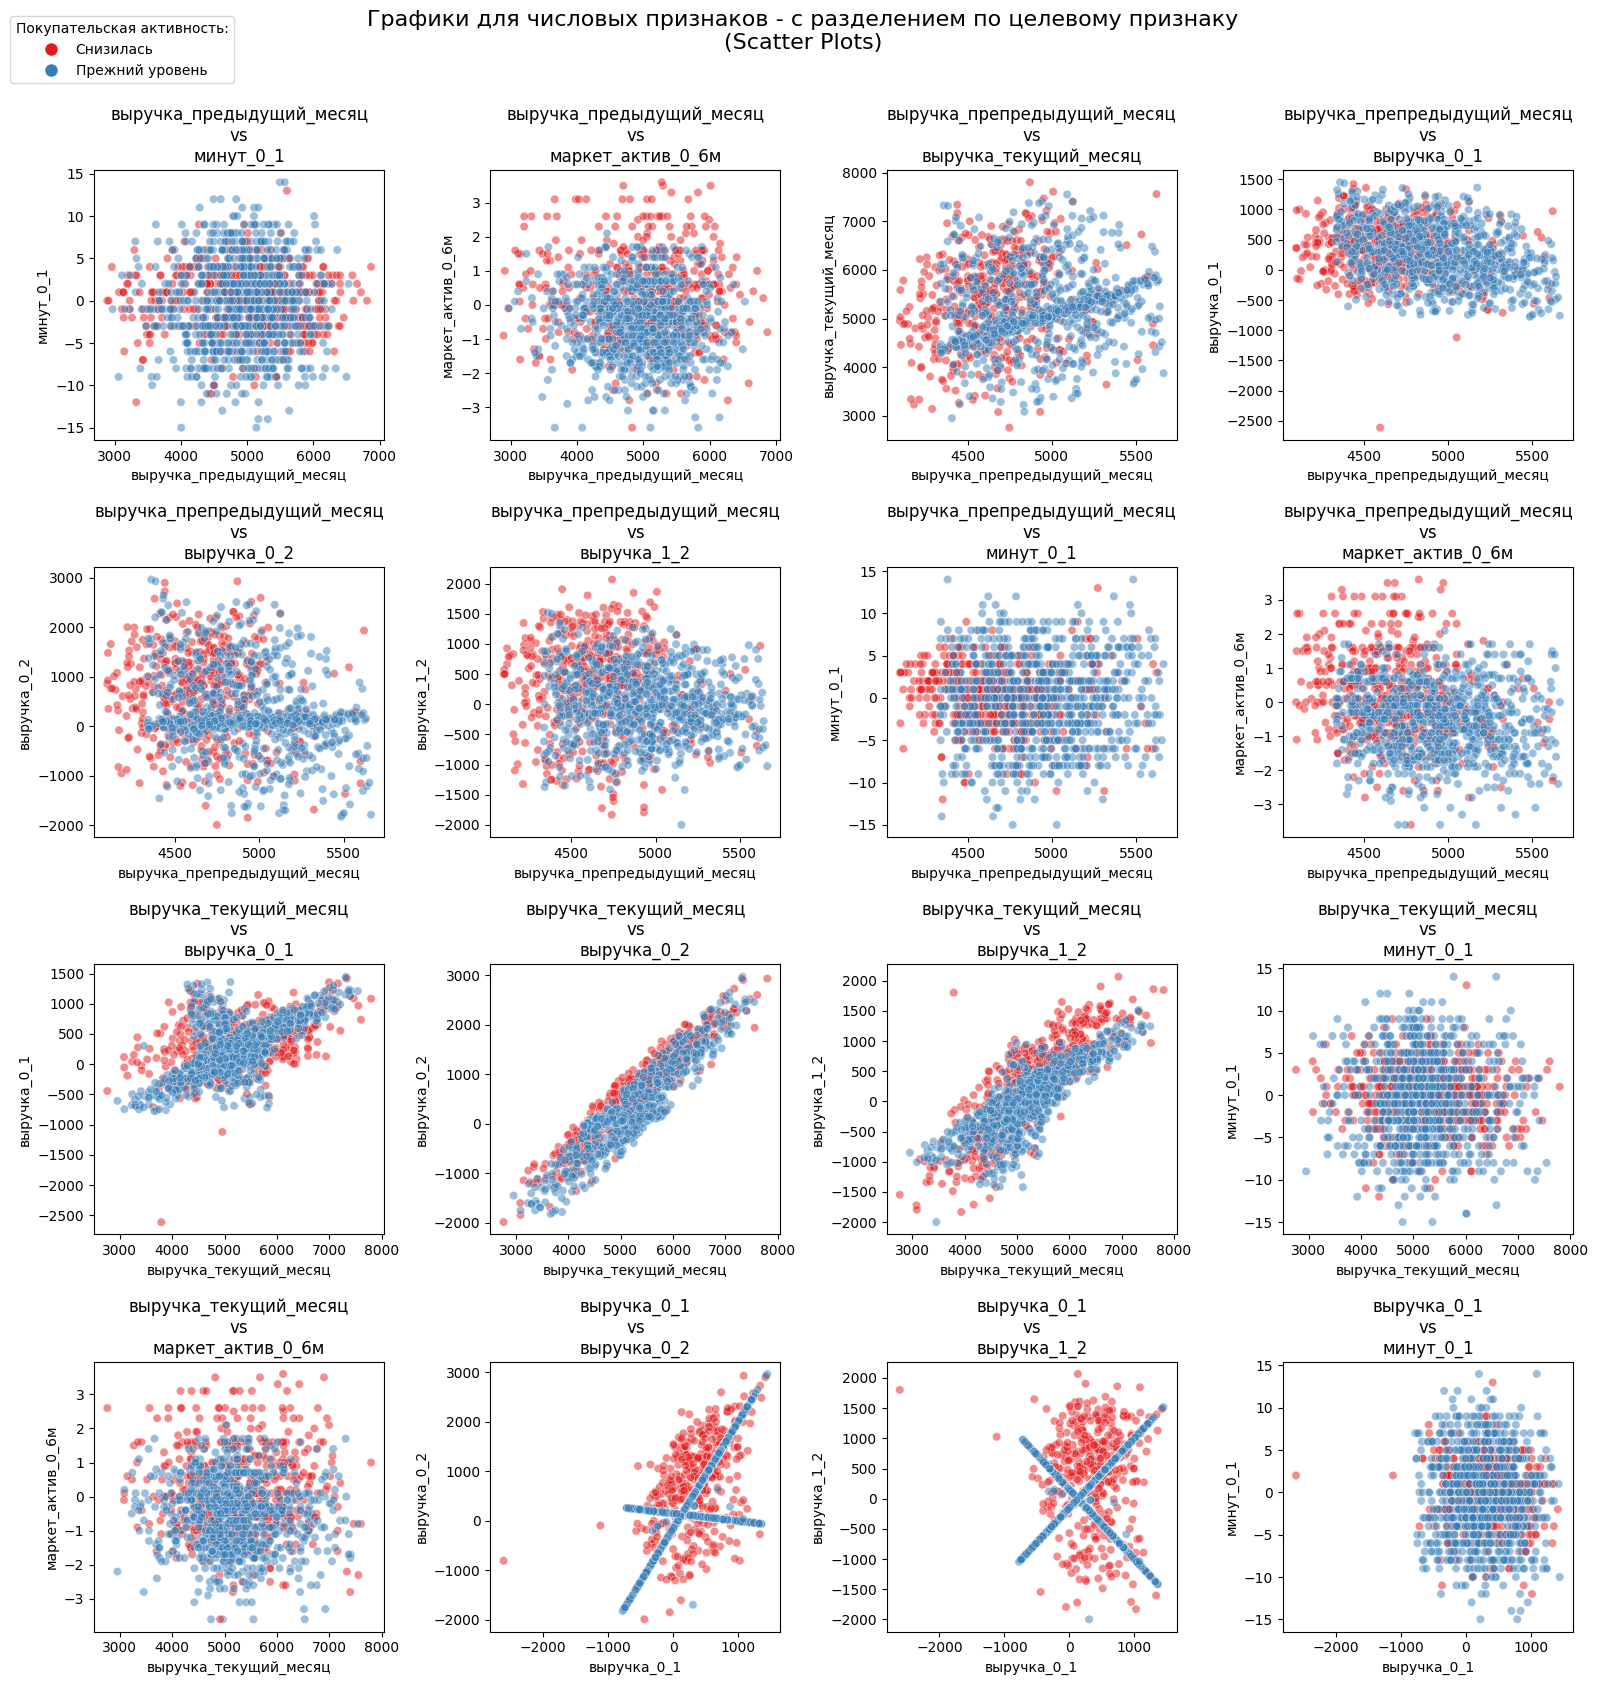

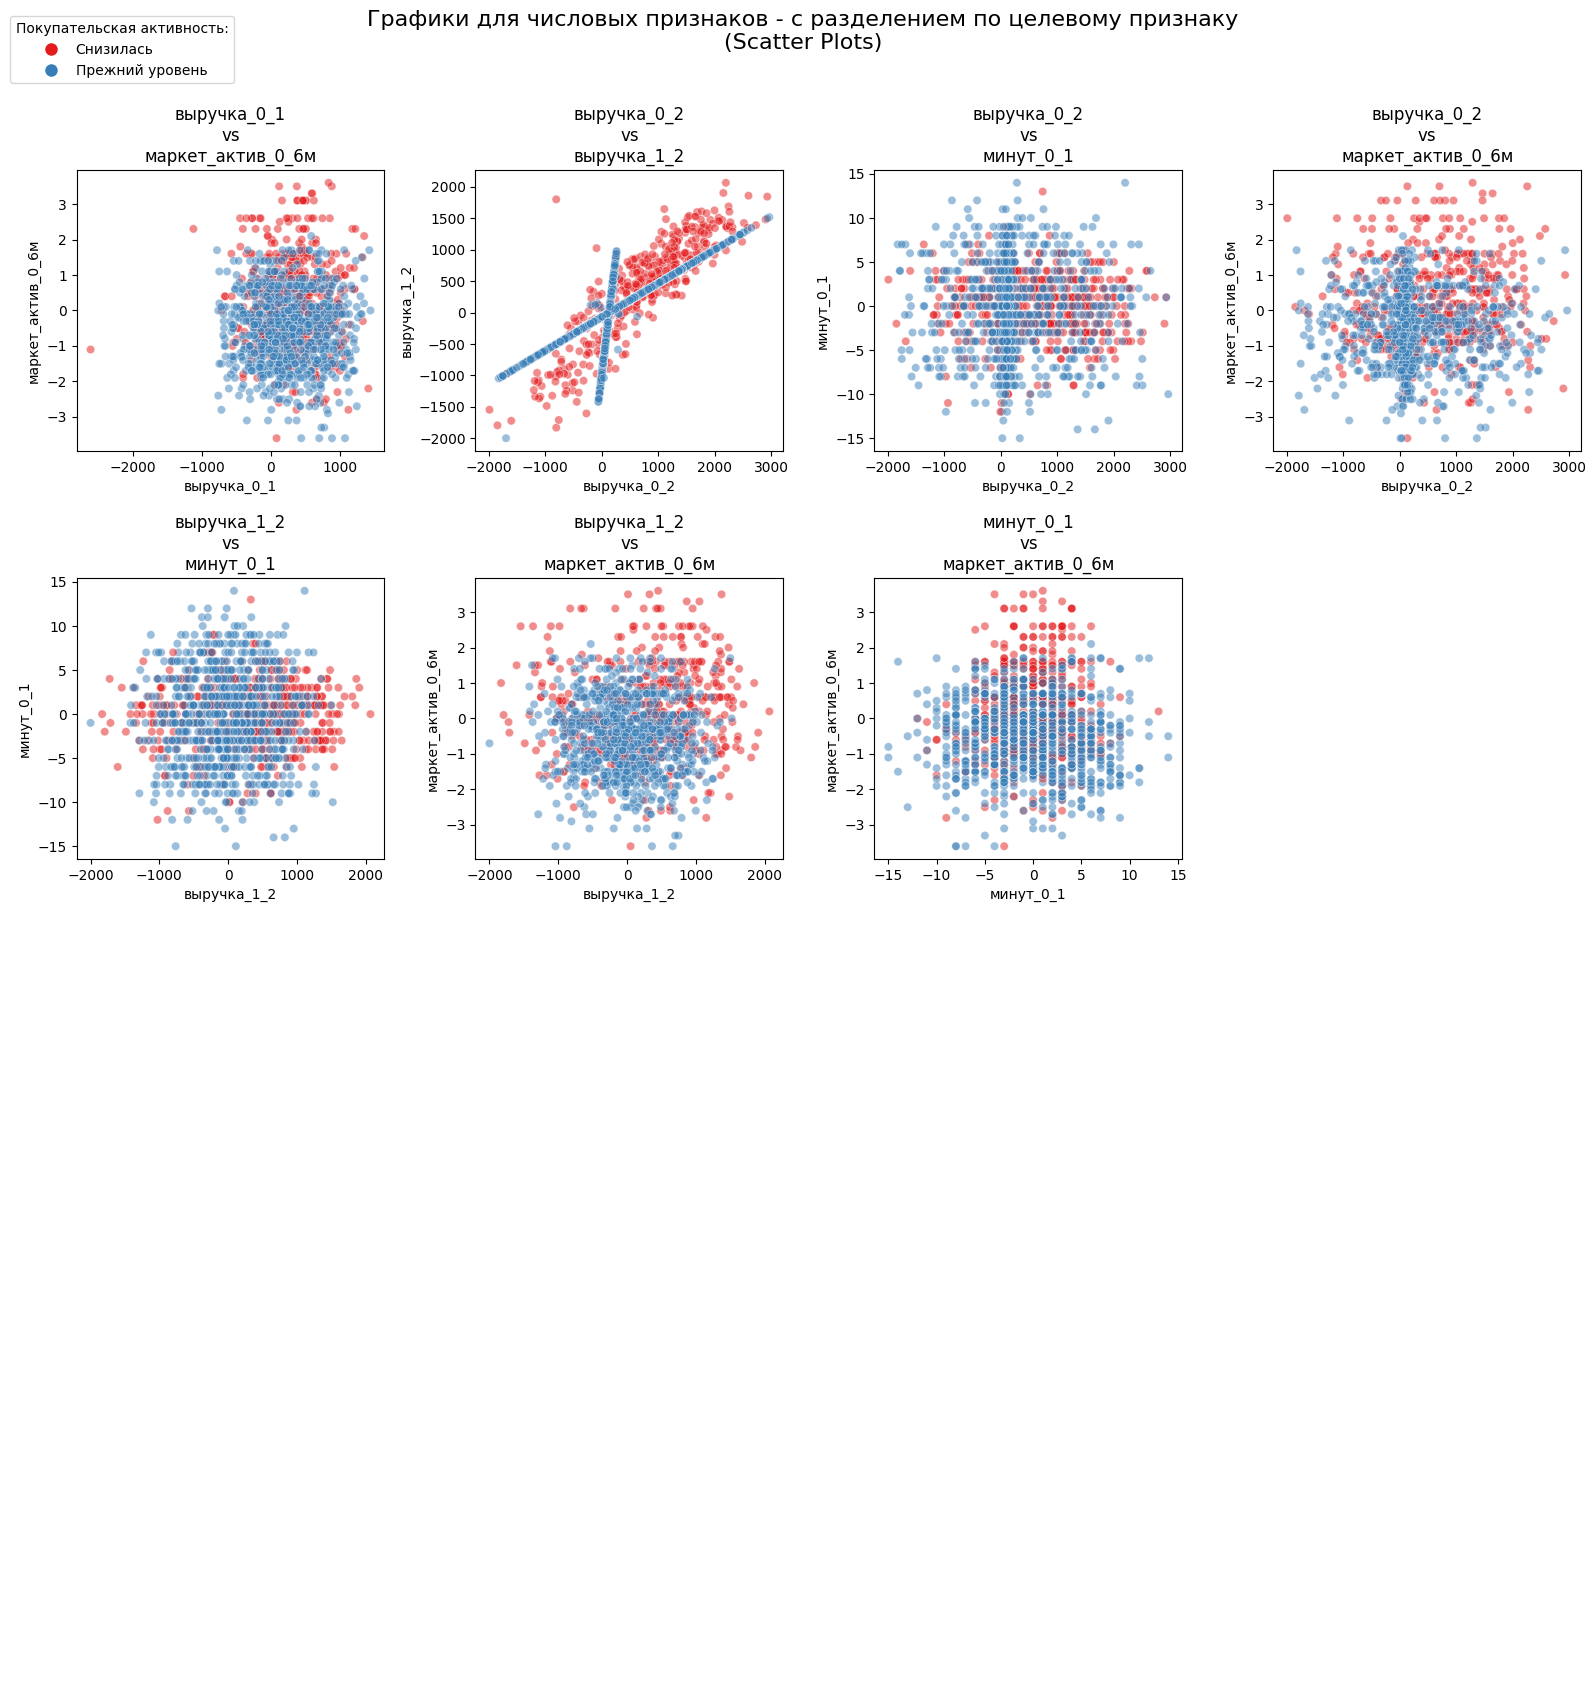

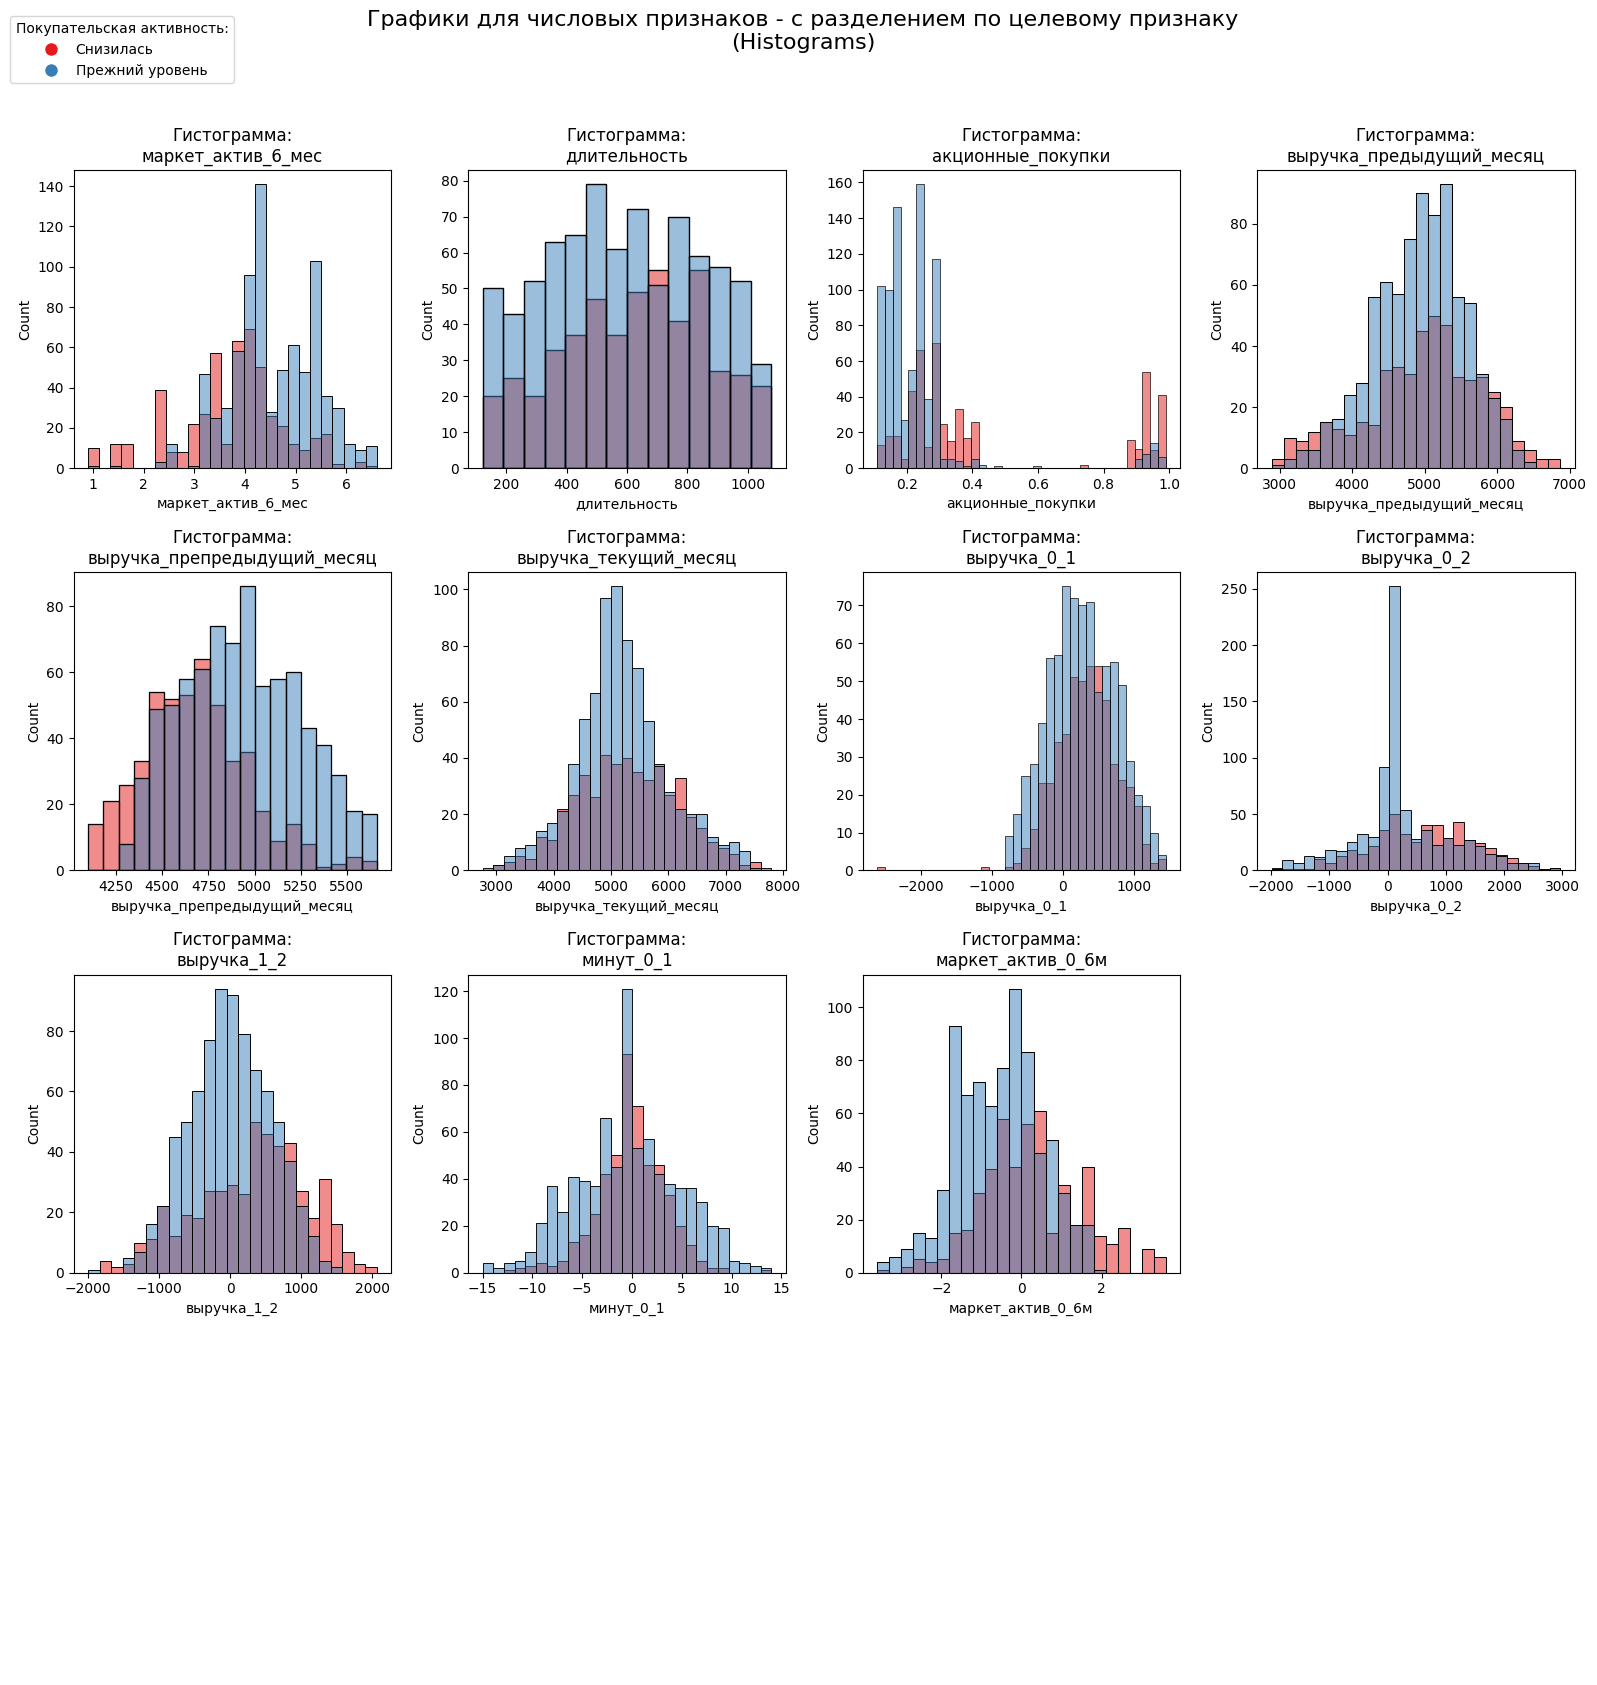

In [36]:
# Scatter-матрицы для числовых признаков с разделением по целевому признаку
scatter_matrix_num_by_cat_subplots(
    df=df_begin,
    name_cols_for_view=num_cols,
    cat_name=target_variable,
    cat_title='Покупательская активность:',
    plots_per_fig=16, # Сколько графиков выводить на одном рисунке
    main_title='Графики для числовых признаков - с разделением по целевому признаку',
)

## Выводы - корреляционный анализ

---
1. **Корреляции целевой переменной со входными признаками**:

- 10 из 21 входных признаков имеют сильные или умеренные корреляции с целевой переменной;
- 11 из 21 входных признаков имеют слабые или не значимые корреляции с целевой переменной;
- максимальная корреляция у входной переменной `страниц_за_визит` (0.75);
- ***нет входных переменных с корреляцией более 0.90-0.95; утечки данных не обнаружено***.

---
2. **Входные признаки со значимыми парными корреляциями**:

2.1. Были введены новые входные признаки, которые были образованы как разность (т.е. по сути линейная комбинация) исходных признаков. Прямое следствие этого:
- присутствуют сильные парные корреляции новых признаков с исходными по группам:
  - выручка/динамика выручки;
  - время на сайте/динамика времени на сайте;
  - маркетинговые коммуникации/динамика маркетинговых коммуникаций;
- в каждой из перечисленных групп признаков нужно оставить один или два (если возможно).

2.2. Есть также умеренные парные корреляции еще по некоторым парам входных признаков:
- тип_сервиса vs длительность.

2.3. Прочие парные корреляции входных признаков слабые или не значимые.

---
3. **Гистограммы числовых признаков (с разделением по целевой переменной)**:

- часть гисторамм показывает логичные зависимости целевой переменной от числового признака, например:
  - малые значения показателя `маркет_актив_6_мес` практически гарантировано дают снижение покупательской активности;
  - чем меньше показатель `страниц_за_визит`, тем выше вероятность снижения покупательской активности;
- часть гистограмм показывают отсутствие четкой закономерности (или сомнительную закономерность).

---
4. **Диаграммы рассеяния по парам числовых признаков (с разделением по целевой переменной)**:

- часть графиков показывает различную кластеризацию точек рассеяния в зависимости от значения целевой переменной;
- на части графиков явно прослеживается концентрация красных меток (снижение активности покупателей) в одной из частей диаграммы;
- на некоторых диаграммах явных различий по расположению/группировке точек разных цветов не наблюдается.

# Отбор входных признаков

## Описание процесса отбора признаков

***При отборе входных признаков применяется следующая методика***:

---
1. На начальном этапе в модель включаются все числовые и все категориальные признаки из основной таблицы, за исключением:
- `id` (номера клиентов);

---
2. В исходный набор переменных были добавлены новые переменные:
- описание этих переменных было дано выше в исследовании.

---
3. Производится исключение входных переменных следующим способом:
- *автоматическое последовательное исключение входных переменных*:
  - анализ изменения VIF (Variance Inflation Factor) при исключении входных признаков;
  - анализ изменения числа обусловленности корреляционной матрицы при исключении входных признаков.

---
4. Далее производится анализ полученного набора входных переменных и делаются выводы.

In [37]:
# функция расчета VIF и числа обусловленности матрицы корреляций
# с предварительным кодированием категориальных признаков
def vif_cond_count(df,
                   step_num,
                   show_table=True,
                   one_step_only=False):
    # Извлечение данных
    num_f = df.select_dtypes(include=['number']).columns.tolist()
    cat_f = df.select_dtypes(exclude=['number']).columns.tolist()

    X_num = df[num_f]
    X_cat = df[cat_f]

    # One-Hot Encoding и замена имен столбцов
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    X_cat_encoded = pd.DataFrame(encoder.fit_transform(X_cat))
    X_cat_encoded.columns = encoder.get_feature_names_out(cat_f)
    X_cat_encoded.index = X_cat.index  # <-- нужный индекс! иначе может падать с ошибкой.

    # Объединение данных
    X_combined = pd.concat([X_num, X_cat_encoded], axis=1).astype(np.float64)

    # расчет VIF
    vif_data = pd.DataFrame(index=X_combined.columns)

    # Список для хранения значений VIF
    vif_values = []

    # Попытка рассчитать VIF для каждого признака
    for i in range(X_combined.shape[1]):
        try:
            vif_val = variance_inflation_factor(X_combined.values, i)
            vif_values.append(round(vif_val, 3))
        except Exception as e:
            print(f'Ошибка при расчете VIF для признака {X_combined.columns[i]}: {e}')
            print(f'Размер матрицы: {X_combined.shape}')
            print(f'Пропущенные значения:')
            print(X_combined.isnull().sum())
            print(f'Бесконечные значения:')
            print((~np.isfinite(X_combined.values)).sum())

            # Остановка функции при ошибке
            print(f'------------------------ ШАГ {step_num} ------------------------')
            print('Расчет VIF прерван из-за ошибки')
            print(f'------------------------ Конец шага {step_num} -----------------', '\n')

            return None, None, None

    vif_data["vif"] = vif_values
    vif_data = vif_data.sort_values(by="vif", ascending=False)

    result = vif_data

    # расчет числа обусловленности корреляционной матрицы
    corr_matrix = X_combined.corr()
    cond_value = round(np.linalg.cond(corr_matrix), 3)
    max_vif = result['vif'].max()
    col_to_del = result['vif'].idxmax()

    # Создаем словарь: закодированные признаки -> исходные категориальные
    cat_mapping = {}
    for i, cat_col in enumerate(cat_f):
        encoded_names = encoder.get_feature_names_out(cat_f)  # получаем все имена
        # находим, какие из них соответствуют cat_col
        prefix = f"{cat_col}_"
        for name in encoded_names:
            if name.startswith(prefix):
                cat_mapping[name] = cat_col

    # Найти, если col_to_del — закодированная категориальная переменная
    original_col_name = col_to_del
    if col_to_del in cat_mapping:
        original_col_name = cat_mapping[col_to_del]

    # вывод результатов
    if one_step_only:
        print(f'Набор признаков:')
        display(num_f + cat_f)
        print(f'\nМаксимальное значение VIF                   : {max_vif}')
        print(f'\nЧисло обусловленности корреляционной матрицы: {cond_value}')
        return
    
    print(f'------------------------ ШАГ {step_num} ------------------------')
    if show_table:
        print('Значения VIF для входных признаков:')
        display(result)
    print(f'Максимальное значение VIF                   : {max_vif}')
    print(f'Число обусловленности корреляционной матрицы: {cond_value}')

    return cond_value, max_vif, original_col_name

## Автоматический отбор признаков

In [38]:
# формирование датасета/набора признаков - начальный вариант
df_model_1 = table_all_data.copy()
cols_to_exclude_1 = ['id', target_variable]
df_model_1 = df_model_1.drop(cols_to_exclude_1, axis=1).reset_index(drop=True)

# пороги остановки автоматического отбора признаков
vif_tsh = 10
cond_value_tsh = 10
max_step = 10

In [39]:
# отбор признаков - автоматический
df_model_1_filtered = df_model_1.copy()
col_to_delete_model_1 = []
step = 0
print (f'\n--------Автоматический отбор признаков запущен---------------\n')
while True:
    condition_value, max_vif_value, col_to_delete = vif_cond_count(df_model_1_filtered,
                                                                   step_num=step,
                                                                   show_table=False)
    exit_condition = ((condition_value < cond_value_tsh) and
                      (max_vif_value < vif_tsh)) or (step == max_step)
    if exit_condition:
        col_to_model_1_filtered = df_model_1_filtered.columns.tolist()
        print (f'\n--------Автоматический отбор признаков завершен--------------')
        print (f'\nИсключенные признаки (по VIF)               :')
        display(col_to_delete_model_1)
        print (f'\nОставшиеся признаки                         :')
        display(col_to_model_1_filtered)
        print (f'\nМаксимальный VIF (оставшиеся признаки)      : {max_vif_value}')
        print (f'\nЧисло обусловленности корреляционной матрицы: {condition_value}')
        break
    step += 1
    print(f'Переменная для удаления на Шаге {step}               : {col_to_delete}\n')
    col_to_delete_model_1.append(col_to_delete)
    df_model_1_filtered = df_model_1_filtered.drop(col_to_delete_model_1[-1], axis=1)


--------Автоматический отбор признаков запущен---------------

------------------------ ШАГ 0 ------------------------
Максимальное значение VIF                   : inf
Число обусловленности корреляционной матрицы: 8863803813912612.0
Переменная для удаления на Шаге 1               : маркет_актив_6_мес

------------------------ ШАГ 1 ------------------------
Максимальное значение VIF                   : inf
Число обусловленности корреляционной матрицы: 5169365113834300.0
Переменная для удаления на Шаге 2               : выручка_предыдущий_месяц

------------------------ ШАГ 2 ------------------------
Максимальное значение VIF                   : inf
Число обусловленности корреляционной матрицы: 1.2950312548784114e+16
Переменная для удаления на Шаге 3               : выручка_1_2

------------------------ ШАГ 3 ------------------------
Максимальное значение VIF                   : inf
Число обусловленности корреляционной матрицы: 9.559352375689832e+16
Переменная для удаления на Шаге 4   

['маркет_актив_6_мес',
 'выручка_предыдущий_месяц',
 'выручка_1_2',
 'выручка_0_2',
 'минут_текущий_месяц',
 'выручка_препредыдущий_месяц',
 'маркет_актив_тек_мес',
 'выручка_текущий_месяц',
 'минут_предыдущий_месяц']


Оставшиеся признаки                         :


['тип_сервиса',
 'разрешить_сообщать',
 'длительность',
 'акционные_покупки',
 'популярная_категория',
 'средний_просмотр_категорий_за_визит',
 'неоплаченные_продукты_штук_квартал',
 'ошибка_сервиса',
 'страниц_за_визит',
 'выручка_0_1',
 'минут_0_1',
 'маркет_актив_0_6м']


Максимальный VIF (оставшиеся признаки)      : 6.664

Число обусловленности корреляционной матрицы: 9.411


## Выводы - отбор входных признаков

---
**Исключенные признаки по группам**:
1. *Группа выручки (и динамики выручки)*:
- Исключены признаки: 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 'выручка_0_2', 'минут_текущий_месяц', 'выручка_1_2':
- данная группа входных признаков заменяется вновь введенным признаком, отражающим динамику выручки по месяцам: 'выручка_0_1'
- разницы в выручке по месяцам с текущим месяцем были автоматически исключены; это в целом выглядит логичным - ведь текущий месяц еще может быть незавершен, и потому анализ динамики выручки с текущим месяцем может быть искаженным.

2. *Группа времени на сайте (и динамики времени на сайте)*:
- Исключены признаки: 'минут_предыдущий_месяц', 'минут_текущий_месяц':
- данная пара признаков заменяется вновь введенным признаком, отражающим динамику времени на сайте по месяцам: минут_0_1.

3. *Группа макетинговой активности (и ее динамики)*:
- Исключенные признаки: 'маркет_актив_тек_мес', 'маркет_актив_6_мес':
  - данная пара признаков заменяется вновь введенным признаком, отражающим динамику маркетинговых коммуникаций по месяцам:  'маркет_актив_0_6м'.

---
**Общий вывод**:

1. Все исключенные признаки были по факту заменены вновь введенными признаками, отражающими динамику изменнений исходных признаков, что более актуально для модели ML при предсказании покупательской активности (пример: если выручка падает, т.е. показатель динамики выручки отрицательный - это маркер снижения покупательской активности, но сам размер выручки в данном случае играет второстепенную роль, т.к. уровень выручки у разных клиентов может отличаться на порядок).
2. Фактически была произведена трасформация и замена признаков с абсолютными значениями в динамике по месяцам на новые признаки, отражающие суть таковой динамики (упал или вырос исходный показатель от периода к периоду).
3. ***Таким образом, можно обоснованно считать, что при введении новых признаков и последующем исключении части как исходных так и вновь введенных признаков, потери информации/данных для обучения модели ML нами не допущено***.

---
| Отбор признаков | Исключенные признаки| Оставшиеся признаки| Максимальный VIF (оставшиеся признаки)| Число обусловленности корреляционной матрицы (оставшиеся признаки)|
|:----------------:|:----------------:|:----------------:|:----------------:|:----------------:|
| Автоматически   | 'маркет_актив_6_мес', 'выручка_предыдущий_месяц', 'выручка_1_2', 'выручка_0_2', 'минут_текущий_месяц', 'выручка_препредыдущий_месяц', 'маркет_актив_тек_мес', 'выручка_текущий_месяц', 'минут_предыдущий_месяц'| 'тип_сервиса', 'разрешить_сообщать', 'длительность', 'акционные_покупки', 'популярная_категория', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_0_1', 'минут_0_1', 'маркет_актив_0_6м'| 6.664 | 9.411 |



# Построение модели ML

## Описание процесса построения модели ML

---
**Цель**:
- разработать модель ML, которая предскажет вероятность снижения покупательской активности клиентов.

---
**Описание решения**:

- решается задача бинарной классификации (покупательская активность: 0 - осталась прежней, 1 - снизилась);
- построение модели ML проводится с использованием различных методов классификации (LogReg, DecisionTree, KNN, SVM);
- для выбора лучшей модели используются пайплайны с перебором гиперпараметров моделей.

## Выбор лучшей модели ML - пайплайн

In [40]:
# формирование датасета/набора признаков - начальный вариант
df_pipe_1 = table_all_data.copy()

# Сохраняем id до удаления
original_ids = table_all_data[['id']].reset_index(drop=True)  # <-- (1) НОВОЕ

# убираем id и все исключенные признаки
cols_to_exclude_pipe_1 = ['id'] + col_to_delete_model_1
df_pipe_1 = df_pipe_1.drop(cols_to_exclude_pipe_1, axis=1)  # <-- (2) УБРАЛИ reset_index(drop=True)

In [41]:
# разбиваем данные на выборки на train и test
X_train, X_test, y_train, y_test = train_test_split(
    df_pipe_1.drop([target_variable], axis=1),
    df_pipe_1[target_variable],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df_pipe_1[target_variable])

# Сохраняем индексы тестовой выборки
test_index = X_test.index  # <-- (3) НОВОЕ

print(X_train.shape, X_test.shape)

(972, 12) (325, 12)


In [42]:
# создаем списки с названиями признаков

# 1. Упорядоченные признаки:
# 'тип_сервиса': стандарт < премиум
# 'разрешить_сообщать': нет < да
ord_columns = ['тип_сервиса', 'разрешить_сообщать']
print(f"ord_columns: {ord_columns}")

# 2. Неупорядоченные признаки:
ohe_columns = df_pipe_1.drop([target_variable] + ord_columns, axis=1)\
    .select_dtypes(exclude=['number']).columns.tolist()
print(f"ohe_columns: {ohe_columns}")

# 3. Числовые признаки:
num_columns = df_pipe_1.drop([target_variable], axis=1)\
    .select_dtypes(include=['number']).columns.tolist()
print(f"num_columns: {num_columns}")

ord_columns: ['тип_сервиса', 'разрешить_сообщать']
ohe_columns: ['популярная_категория']
num_columns: ['длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_0_1', 'минут_0_1', 'маркет_актив_0_6м']


In [43]:
# пайплайн для подготовки признаков из списка ohe_columns:
# заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe',
      SimpleImputer(missing_values=np.nan,
                    strategy='most_frequent')
     ),
     ('ohe',
      OneHotEncoder(drop='first',
                    handle_unknown='ignore',
                    sparse_output=False)
     )
    ]
    )

# пайплайн для подготовки признаков из списка ord_columns:
# заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord',
      SimpleImputer(missing_values=np.nan,
                    strategy='most_frequent')
     ),
     ('ord',
      OrdinalEncoder(categories=[['стандарт', 'премиум'],
                                 ['нет', 'да']],
                     handle_unknown='use_encoded_value',
                     unknown_value=np.nan)
     ),
     ('simpleImputer_after_ord',
      SimpleImputer(missing_values=np.nan,
                    strategy='most_frequent')
     )
    ]
    )

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# итоговый пайплайн: подготовка данных и модель
pipe_final_1 = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [44]:
# параметры моделей

param_grid_1 = [
    # Словарь для модели DecisionTreeClassifier
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(3, 11),
        'models__min_samples_split': [2, 5, 10],
        'models__min_samples_leaf': [1, 2],
        'models__criterion': ['gini', 'entropy'],
        'models__max_features': [None, 'sqrt'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    
    # Словарь для модели KNeighborsClassifier
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': [5, 7, 9, 11, 13],
        'models__weights': ['uniform', 'distance'],
        'models__metric': ['euclidean', 'manhattan'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },

    # Словарь для модели LogisticRegression
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': [0.1, 1.0, 10.0],
        'models__penalty': ['l2', 'l1'],
        'models__solver': ['liblinear', 'saga'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },

    # Словарь для модели SVC
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': [0.1, 1.0, 10.0],
        'models__kernel': ['linear', 'rbf'],
        'models__gamma': ['scale', 'auto'],
        'preprocessor__num': [StandardScaler()]
    }
]

**Выбор метрики для оценки качества моделей**:

- в целевой переменной присуствует дисбаланс классов (порядка 62%/38%);
- ***выводы - выбор метрики***:
  - в данном случае в качестве метрики для сравнения качества моделей выбираем метрику `ROC AUC`;
  - данная метрика слабо чуствительна к дисбалансу классов и оценивает качество разделения на классы в целом.

In [45]:
# метрика
metric='roc_auc'

# стратификая при разбиении
cv_1 = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [46]:
# поиск лучшей модели
grid_search = GridSearchCV(
    pipe_final_1, 
    param_grid_1, 
    cv=cv_1,
    scoring=metric,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=99, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['популярная...
                          'models__C': [0.1, 1.0, 10.0],
                          'models__penalty': ['l2', 'l1'],
                          'models__solver': ['liblinear', 'saga'],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler()]},
                         {'models': [SVC(probability=True, random_state=99)],
                          'models__C': [0.1, 1.0, 10.0],
                          'models__gamma': ['scale', 'auto'],
                          'models__kernel': ['linear', 'rbf'],
                          'preprocessor__num': [StandardScaler()]}],
             scoring='roc_auc')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
           

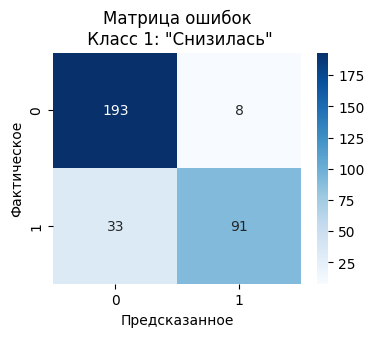

In [47]:
print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_, '\n')

# проверим работу модели на тестовой выборке
y_test_pred = grid_search.best_estimator_.predict_proba(X_test)[:,1]

predictions = grid_search.best_estimator_.predict(X_test)

# Анализ качества прогноза

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary', pos_label='Снизилась')
recall = recall_score(y_test, predictions, average='binary', pos_label='Снизилась')
f1_sc = f1_score(y_test, predictions, average='binary', pos_label='Снизилась')
conf_matrix = confusion_matrix(y_test, predictions, labels=['Прежний уровень', 'Снизилась'])

print('Метрики прогноза на тестовой выборке\n-------------------------------------------------')
print(f'Accuracy                : {accuracy:.3f}')
print(f'Precision               : {precision:.3f}')
print(f'Recall                  : {recall:.3f}')
print(f'F1                      : {f1_sc:.3f}')

# визуализация для анализа качества модели
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок\n Класс 1: "Снизилась"')
plt.xlabel('Предсказанное')
plt.ylabel('Фактическое')
plt.show()

## Выбор лучшей модели ML - итоги

***Что было сделано***:

- построение модели ML проведено с использованием различных методов классификации (LogReg, DecisionTree, KNN, SVM);
- для выбора лучшей модели применялся пайплайн с перебором гиперпараметров моделей;
- метрика для сравнения качества моделей: `ROC AUC`.

***Итоги работы***:

- лучшая модель по выбранной метрике: `SVC(probability=True)`;
- прочие параметры в модели `SVM` по умолчанию, значит ядро модели: `rbf` - это нелинейная модель.

# Анализ важности признаков

## Анализ значений SHAP

In [48]:
# Подготовка данных для SHAP-визуализации
final_model = grid_search.best_estimator_
model_without_preprocessor = final_model.named_steps['models']
preprocessor = final_model.named_steps['preprocessor']

# Получаем имена признаков после преобразования
feature_names = preprocessor.get_feature_names_out()

# Преобразуем X_train и X_test
X_train_transformed = preprocessor.transform(X_train)
X_train_transformed_df = pd.DataFrame(
    X_train_transformed,
    columns=feature_names
)

X_test_transformed = preprocessor.transform(X_test)
X_test_transformed_df = pd.DataFrame(
    X_test_transformed,
    columns=feature_names
)

In [49]:
X_train_summary = shap.kmeans(X_train_transformed_df, 50)

# Используем только .data
X_train_summary_data = X_train_summary.data

# Создаём SHAP-объект
def model_predict_proba(X):
    return model_without_preprocessor.predict_proba(X)

explainer = shap.Explainer(
    model_predict_proba,
    X_train_summary_data,  # передаём .data
    output_type="probability"
)

# Вычисляем вручную expected_values
expected_vals = model_predict_proba(X_train_summary_data).mean(axis=0)

X_test_subset = X_test_transformed_df# .iloc[:50]  # первые 50 строк - для тестирования

In [50]:
# Вычисляем SHAP-значения
shap_values = explainer(X_test_subset)

PermutationExplainer explainer: 326it [05:16,  1.03it/s]                                                               


In [51]:
# shap_values — shap.Explanation
# shap_values.values.shape = (n_samples, n_features, 2) для бинарной задачи
# Если 3D — значит, для каждого класса
if len(shap_values.values.shape) == 3:
    shap_values_class_1 = shap_values.values[:, :, 1]  # для класса 1
    base_values_class_1 = shap_values.base_values[:, 1]  # базовые значения для класса 1
else:
    shap_values_class_1 = shap_values.values
    base_values_class_1 = shap_values.base_values

# Создаем shap.Explanation для класса 1
shap_values_binary = shap.Explanation(
    values=shap_values_class_1,
    base_values=base_values_class_1,
    data=X_test_subset.values,
    feature_names=X_test_subset.columns.tolist()
)

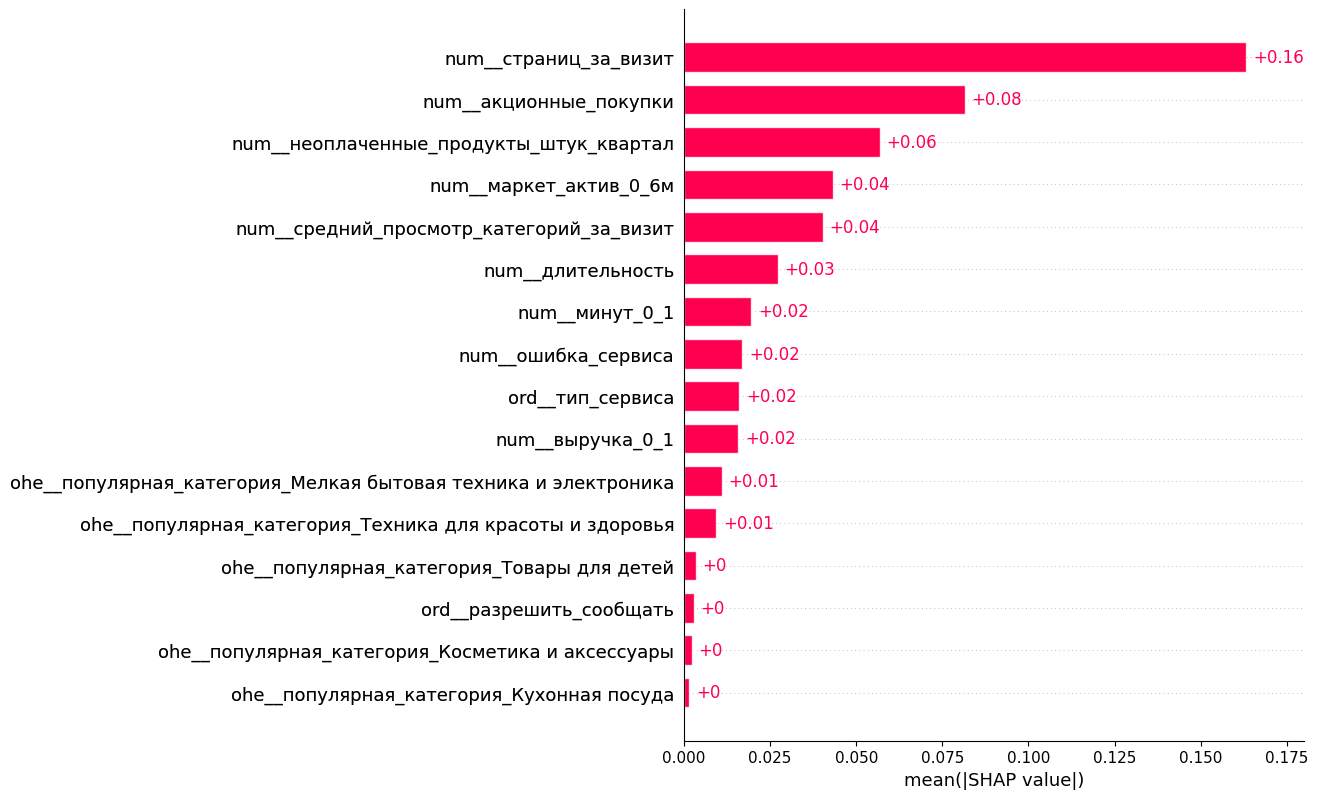

In [66]:
# посторение графика 1
plt.figure(figsize=(10, len(shap_values_binary.feature_names) * 0.4))
shap.plots.bar(shap_values_binary, max_display=None)
plt.show()

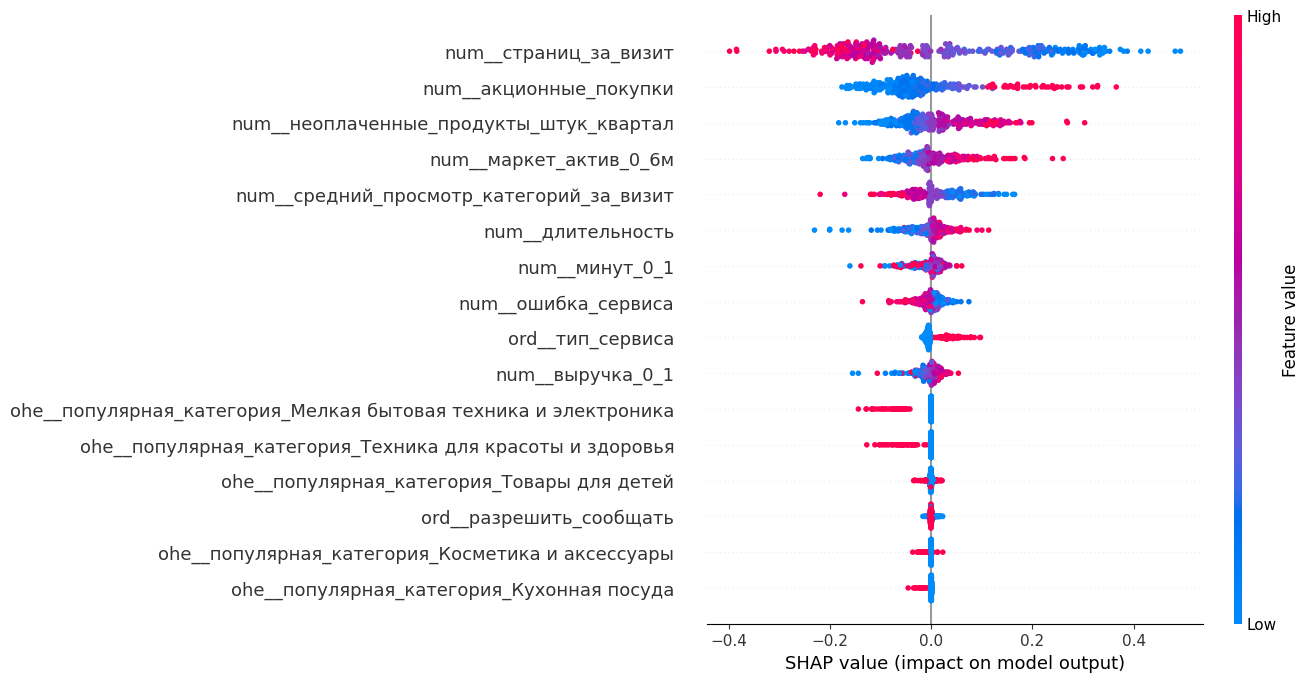

In [67]:
# посторение графика 2
plt.figure(figsize=(10, len(shap_values_binary.feature_names) * 0.4))
shap.plots.beeswarm(shap_values_binary, max_display=None)
plt.show()

## Выводы - важность признаков

---
*Анализ важности признаков основан на двух графиках SHAP (см. выше)*:

1. Первый график (красные bar-plot):
- показывает ***среднюю абсолютную важность*** каждого признака.
- Чем длиннее bar-полоса, тем больше среднее влияние признака на предсказание модели (при этом направление влияния признака не учитывается).

2. Второй график (двух-цветный scatter по каждому признаку):
- Показывает ***направление и силу влияния*** каждого признака.
- Красный цвет — высокие значения соответствующего признака, синий — низкие значения.
- Точки справа от нуля увеличивают вероятность класса 1 (снижение активности), точки слева — уменьшают.

---
***Признаки, которые мало значимы для модели***:

Из первого графика: признаки со средними SHAP значениями близкими к 0.00 или 0.01 имеют крайне низкое влияние на итоговый прогноз (не информативны, либо крайне мало информативны):
- `ord_разрешить_сообщать` (разрешение на рассылку);
- ***все ohe-кодированные*** признаки, полученные из переменной `популярная_категория`;
- `num_минут_0_1` (разница в длительности посещения): Снижение или увеличение времени на сайте *в текущем месяце* по сравнению с предыдущим месяцем  *в среднем мало влияет* на вероятность снижения активности покупателей.

***Заключение***: Указанные выше признаки можно исключить из модели без существенной потери качества прогноза. Это упростит модель, повысит интерпретируемость и может улучшить (либо нет) обобщающую способность модели.

---
***Признаки, которые существенно значимы для модели***:

1. `num_страниц_за_визит` (среднее количество страниц за визит на сайт): **0.16**.

- *Анализ*: самый важный признак. **Высокие значения** признака (красные точки) ***смещают SHAP-значения влево***, уменьшая вероятность снижения активности.
- *Интерпретация*: Положительный признак — пользователь активно интересуется сайтом, исследует. Это признак высокой вовлеченности и потенциальной лояльности.

2. `num_акционные_покупки` (Доля покупок по акциям): **0.08**.

- *Анализ*: второй по важности признак. **Высокие значения** признака (красные точки) ***смещают SHAP-значения вправо***, увеличивая вероятность снижения активности.
- *Интерпретация*: Высокая доля покупок по акции — тревожный сигнал. Это указывает на зависимость клиента от скидок и потенциальный риск оттока, если таких скидок далее не будет.

3. `num_неоплаченные_продукты_штук_квартал` (общее число неоплаченных товаров в корзине за последние 3 месяца): **0.06**.

- *Анализ*: **Высокие значения** признака (красные точки) ***смещают SHAP-значения вправо***, увеличивая вероятность снижения активности.
- *Интерпретация*: указывает на пользователей, которые добавляют товары в корзину, но не завершают покупку; это может быть связано как с колебаниями пользователя, так и с проблемами на этапе оплаты; это тревожный сигнал.

4. `num_средний_просмотр_категорий_за_визит` (Среднее количество просмотров категорий за визит): **0.04**.

- *Анализ*: **Высокие значения** признака (красные точки) ***смещают SHAP-значения влево***, уменьшая вероятность снижения активности.
- *Интерпретация*: Положительный признак — пользователь активно изучает ассортимент, что говорит о его интересе и вовлеченности.

5. `num_маркет_актив_0_6м` (Разница в числе маркетинговых коммуникаций с клиентом текущего месяца и среднего за 6 предыдущих месяцев): **0.04**.

- *Анализ*: **Высокие значения** признака (красные точки) ***смещают SHAP-значения вправо***, увеличивая вероятность снижения активности.
- *Интерпретация*: положительное значение признака означает, что в текущем месяце пользователь получил больше маркетинговых коммуникаций, чем в среднем за предыдущие 6 месяцев; слишком частые рассылки могут раздражать и приводить к оттоку пользователей.

6. `num_выручка_0_1` (Разница в выручке между текущим и предыдущим месяцем): **0.02**.

- *Анализ*: **Высокие значения** признака (красные точки) ***в основном смещают SHAP-значения вправо***, увеличивая вероятность снижения активности.
- *Интерпретация*: Это несколько парадоксальный, но важный вывод: резкий рост выручки в текущем месяце может быть предвестником снижения активности в дальнейшем. Возможно, это была покупка крупной/дорогой вещи, или клиент мог исчерпать бюджет.

7. `num_длительность` (Как долго клиент зарегистрирован на сайте): **0.03**.

- *Анализ*: **Высокие значения** признака (красные точки) ***смещают SHAP-значения вправо***, увеличивая вероятность снижения активности.
- *Интерпретация*: Парадоксальный, но важный вывод: чем дольше клиент зарегистрирован на сайте, тем выше вероятность, что его активность снизится. Долгосрочные клиенты — не всегда "золотые". Их нужно активно удерживать, предлагая свежие впечатления, персонализированные предложения, обновленные программы лояльности - чтобы предотвратить "усталость" клиента.

8. `num_ошибка_сервиса` (Общее число ошибок сервиса/сайта, которое коснулось покупателя): **0.02**.

- *Анализ*: **Высокие значения** признака (красные точки) ***смещают SHAP-значения влево***, уменьшая вероятность снижения активности.
- *Интерпретация*: Это неожиданный, но важный вывод: пользователи, которые столкнулись с ошибками, не уходят, а наоборот, не становятся менее активными? Возможные объяснения:
  - Пользователь, который столкнулся с ошибкой, обращается в поддержку, получает помощь и/или компенсацию, что может даже усилить его лояльность.
  - Ошибки были незначительными и в целом не помешали покупкам.

9. `ord_тип_сервиса` (Тип сервиса клиента: Стандарт/Премиум): **0.02**.

- *Анализ*: **Высокие значения** признака (красные точки) ***смещают SHAP-значения вправо***, увеличивая вероятность снижения активности.
- *Интерпретация*: Это неожиданный, но важный вывод: пользователи на Премиум подписке, более склонны к снимжению активности? Возможные объяснения:
  - Пользовател и сПремиум подпиской возмодно ожидают дополнительных скидок/акций и/или изменнений в программе лояльности.

## Выводы - рекомендации для бизнеса

---
Как можно использовать приведенный выше анализ признаков при принятии бизнес-решений (некоторые рекомендации):

1. Поддержка активных пользователей:

- `num_страниц_за_визит` и `num_средний_просмотр_категорий_за_визит` — положительные индикаторы; нужно поддерживать интерес активных клиентов.

2. Работа с "акционными" клиентами:

- `num_акционные_покупки (доля)` — ключевой индикатор риска; нужно работать над удержанием таких клиентов, не прекращая предоставление им акций и скидок.

3. Работа с "корзинами покупок":
- `num_неоплаченные_продукты_штук_квартал` — важный индикатор; можно внедрить напоминания об неполаченных товарах/заказах; однако тут важно "не навредить" (см. ниже п. 4).

4. Оптимизация маркетинговых коммуникаций:

- `num_маркет_актив_0_6м` — необходимо избегайть "перегрузки" клиента предожениями/уведомлениями от сайта.

5. Работа со "старыми" клиентами:
- Долгосрочная регистрация (высокое значение num_длительность) — тревожный сигнал. Старожилы сайта обладают высоким риском снижения активности.
- Необходимо:
  - Внедрить систему мониторинга "старых" клиентов с низкой активностью.
  - Разработать персонализированные кампании "оживления" для таких клиентов (например, "Привет, давно не видели! У нас для вас что-то особенное"). Однако здесь нужно не навредить - см. выше п. 4.
  - Проводить анализ, чем отличаются "уставшие" долгосрочные клиенты от "лояльных" долгосрочных клиентов.

# Сегментация покупателей

## Объединение данных



In [54]:
# создаем датафрейм с вероятностью Класса 1 (снижение активности) и добавляем id
data_precict_proba = pd.DataFrame(y_test_pred, columns=['вероятность_снижения'])
data_precict_proba['id'] = original_ids.iloc[test_index].values

# переставляем id на первое место
cols = ['id'] + [col for col in data_precict_proba.columns if col != 'id']
data_precict_proba = data_precict_proba[cols]

In [55]:
# восстанавливаем id для X_test
X_test_with_id = X_test.reset_index(drop=True)
X_test_with_id['id'] = original_ids.iloc[test_index].values

# объединяем X_test и data_precict_proba по id
final_result = pd.merge(data_precict_proba, X_test_with_id, on='id', how='left')

# добавляем ранее исключенные переменные
cols_to_merge = ['id'] + [col for col in table_all_data.columns if col not in final_result.columns]
table_all_data_filtered = table_all_data[cols_to_merge]

final_result = pd.merge(final_result, table_all_data_filtered, on='id', how='left')

# объединяем полученное и данные о средней прибыли с покупателей по id
final_result = pd.merge(final_result, df_all['money'], on='id', how='left')

## Сегмент покупателей - широкий

In [56]:
# функция для построения scatter с разделением на кластеры
def scatter_show_with_h_v_lines (
    df,
    x_col,
    y_col,
    v_line_val=None,
    h_line_val=None,
    cond=None,
    hue=None,
    figsize=(4, 4),
    title=None
):

    """
    Строит scatter plot по двум колонкам,
    добавляет вертикальную и горизонтальную линии.
    Может фильтровать данные по условию и разделять по hue.
    """
    # применяем фильтр, если он задан
    if cond is not None:
        df = df[cond(df)]

    if v_line_val is None:
        v_line_val = df[x_col].mean()
    if h_line_val is None:
        h_line_val = df[y_col].mean()

    if hue is not None:
        sns.scatterplot(data=df, x=x_col, y=y_col, hue=hue)
    else:
        plt.scatter(df[x_col], df[y_col])
    plt.axvline(x=v_line_val, color='red', linestyle='--', linewidth=1)
    plt.axhline(y=h_line_val, color='red', linestyle='--', linewidth=1)

    plt.xlabel(x_col)
    plt.ylabel(y_col)

    if title:
        plt.title(title)
    
    plt.show()
    return

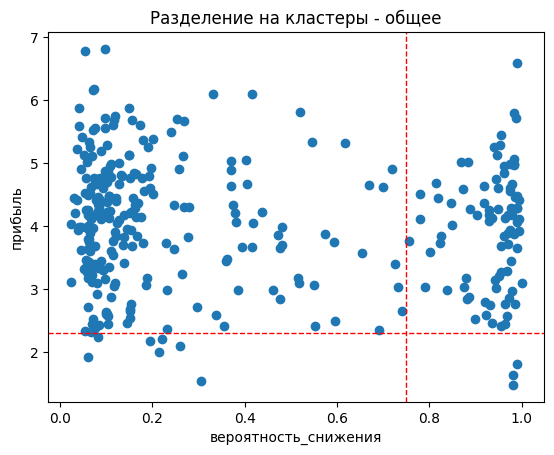

In [57]:
# общее деление на кластеры, подбор границ
scatter_show_with_h_v_lines (
    df=final_result,
    x_col='вероятность_снижения',
    y_col='прибыль',
    v_line_val=0.75,
    h_line_val=2.3,
    cond=None,
    title='Разделение на кластеры - общее')

***Эмпирически подобраны границы*** для разделения покупателей:

- высокая вероятность снижения активности: >= 0.75;
- средняя прибыль за 3 месяца: >= 2.30.

То есть ***отбираем покупателей из правого верхнего прямоугольника***.

**Описание широкого сегмента покупателей**:
- выбраны покупатели с высокой вероятностью снижения активности (не менее 75%);
- отброшены покупатели с низкой прибыльностью (прибыль менее 2.30).

In [58]:
# пороги и первичное условие отбора покупателей
prob_tsh = 0.75
profit_tsh = 2.3
filter_1 = (final_result['вероятность_снижения'] >= prob_tsh) &\
    (final_result['прибыль'] >= profit_tsh)

segment_filtered_1 = final_result[filter_1]
    
print(f"Всего отобрано покупателей: {segment_filtered_1.shape[0]}")

Всего отобрано покупателей: 84


In [59]:
# функция отрисовки boxplot
def create_boxplot(df, value_col, category_col,
                   title="Boxplot",
                   xlabel="Category",
                   ylabel="Value", 
                   figsize=(6, 8), color='lightblue',
                   xrot=90, grid_alpha=0.7):
    """
    Создает boxplot для указанного столбца,
    разделенного по иному (строго категориальному) столбцу.
    """
    plt.figure(figsize=figsize)
    box_plot = plt.boxplot(
        [df[df[category_col] == cat][value_col].values
         for cat in df[category_col].cat.categories],
        labels=df[category_col].cat.categories,
        patch_artist=True,
        boxprops=dict(facecolor=color),
        showfliers=True
    )

    plt.title(title, fontsize=12)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=xrot)
    plt.grid(axis='y', linestyle='--', alpha=grid_alpha)
    plt.tight_layout()
    plt.show()

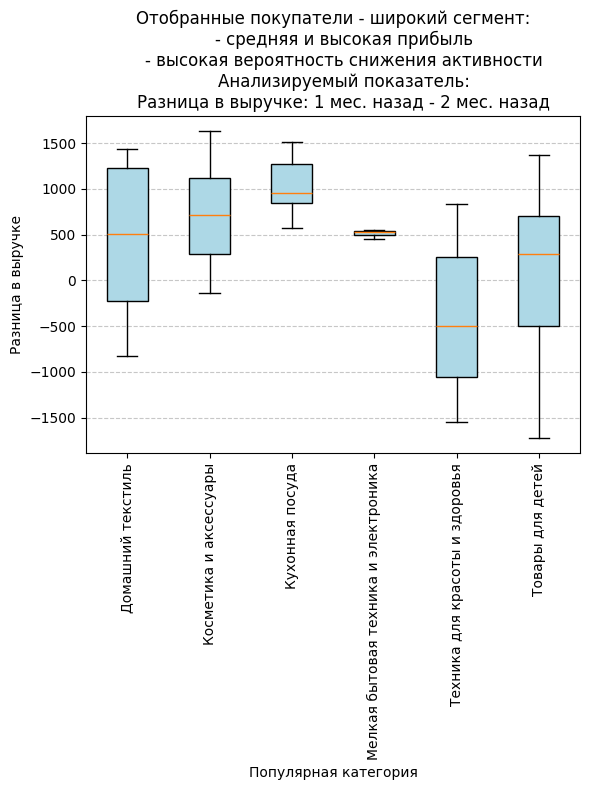

In [60]:
# boxplot 1: разница в выручке
create_boxplot(
    df=segment_filtered_1,
    value_col='выручка_1_2',
    category_col='популярная_категория',
    title=f'Отобранные покупатели - широкий сегмент:\n\
    - средняя и высокая прибыль\n\
    - высокая вероятность снижения активности\n\
    Анализируемый показатель:\n\
    Разница в выручке: 1 мес. назад - 2 мес. назад',
    xlabel='Популярная категория',
    ylabel='Разница в выручке',
    xrot=90
)

In [61]:
print(f"Широкий сегмент покупателей.\n\
Число покупателей по подгруппам (категории товаров)\n")
print(segment_filtered_1.groupby('популярная_категория')['id'].count())

Широкий сегмент покупателей.
Число покупателей по подгруппам (категории товаров)

популярная_категория
Домашний текстиль                       18
Косметика и аксеcсуары                  20
Кухонная посуда                          7
Мелкая бытовая техника и электроника     3
Техника для красоты и здоровья           8
Товары для детей                        28
Name: id, dtype: int64


## Выводы - широкий сегмент

---
**Описание - широкий сегмент покупателей**:
- выбраны покупатели с высокой вероятностью снижения активности (не менее 75%);
- отброшены покупатели с низкой прибыльностью (прибыль менее 2.30).

Общее число отобранных покупателей: **83** - что составляет **25,6%** от выборки.

---
**Особенности - широкий сегмент покупателей**:
- группа `Мелкая бытовая техника и электроника` в данном сегменте покупателей **не репрезентативна** (только 2 покупателя в группе), исключаем из анализа.

---
**Общий анализ - широкий сегмент покупателей**:
- анализируется показатель роста/падения выручки покупателей (разница между выручкой 1 мес. назад и 2 мес. назад), т.е. переменная `выручка_1_2`;
- самая устойчивая категория в сегменте: `Кухонная посуда`:
  - медиана роста выручки положительная, разброс значений роста выручки наименьший из всех категорий;
- первая "проблемная" категория в сегменте: `Техника для красоты и здоровья`:
  - медиана роста выручки околонулевая, разброс значений роста выручки высокий;
  - *товары данной категории можно отнести товарам долгосрочного использования* (например - электрический фен, либо электрическая зубная щетка);
  - ***вывод: отсуствие роста сумм покупок в данном сегменте не является аномалией***;
- вторая "проблемная" категория в сегменте: `Товары для детей`:
  - медиана роста выручки минимальная из отличных то нуля, разброс значений роста выручки высокий;
  - *в товарах данной категории очевидно присуствуют товары с разным сроком использования* (например - велосипед имеет значительно более долгий срок использования по отношению к носочной паре);
  - ***вывод: отсуствие существенного роста сумм покупок в данном сегменте может являтся тревожным сигналом, но может быть и связано с сезонными факторами (покупки в августе перед учебным годом)***;
- покупки в прочих категориях демонстрируют рост медианных значений при среднем разбросе значений роста выручки.

---
***Общие выводы***:

1. *Цели бизнеса*:
- очевидно, что бизнес захочет иметь либо стабильный рост выручки от клиентов, либо стабильный размер выручки;
- при этом НЕ должна существенно снижаться покупательская активность и лояльность клиентов в целом;

2. *Некторые ограничения, вытекающие из анализа влияния предикторов на прогноз вероятности снижения покупательской активности*:
- нельзя чрезмерно перегружать клиента маркетинговыми коммуникациями: это фактор который в целом ведет к потерям лояльности клиентов;
- любители покупок по акциям - клиенты с повышенным риском снижения активности.

3. ***Дальнейшие действия***:
- из отобранного широкого сегмента покупателей выберем более узкий сегмент по двум признакам:
  - высокие доли покупок по акции;
  - уровень маркетинговых коммуникаций в текущем месяце или ниже, или равен, или не сильно превышает уровень маркетинговых коммуникаций в среднем за 6 предыдущих месяцев.

## Сегмент покупателей - узкий

Среди отобранных покупателей (широкий сегмент) ***выделим подсегмент покупателей*** у которых:

- высокая доля покупок по акции (35% и более);
- маркетинговая активность в текущем месяце не сильно превышает (или ниже) среднего показателя за передыдущие 6 мес. (переменная `маркет_актив_0_6м` имеет значение не более +1.0).

In [62]:
# пороги и вторичные условия отбора покупателей
# высокая доля покупок по акции +
# приемлемый уровень маркетинговой коммуникации в текущем месяце
# по отношению к среднему показателю за 6 мес.
actions_tsh = 0.35
marketing_dinamic_tsh = 1.0
filter_2 = (segment_filtered_1['акционные_покупки'] >= actions_tsh) &\
    (segment_filtered_1['маркет_актив_0_6м'] < marketing_dinamic_tsh)

segment_filtered_2 = segment_filtered_1[filter_2]
    
print(f"Всего отобрано покупателей: {segment_filtered_2.shape[0]}")

Всего отобрано покупателей: 26


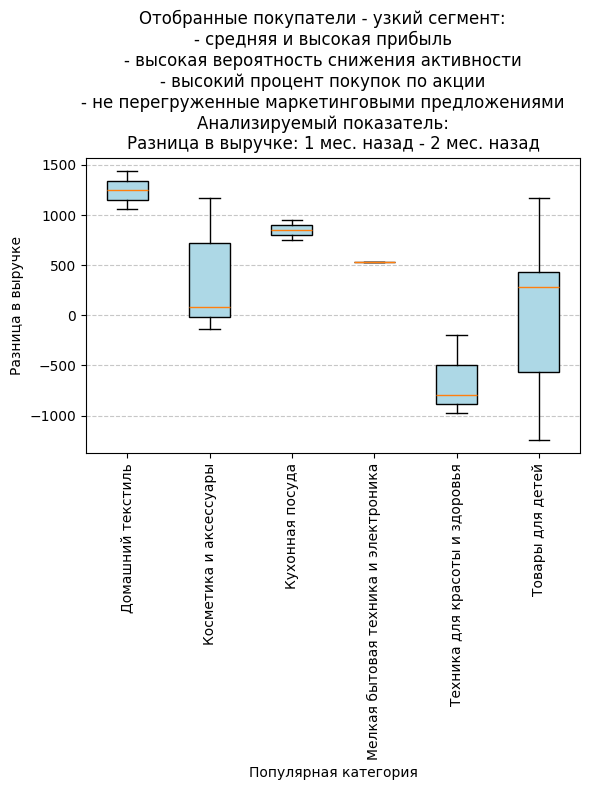

In [63]:
# boxplot 2: разница в выручке
create_boxplot(
    df=segment_filtered_2,
    value_col='выручка_1_2',
    category_col='популярная_категория',
    title='Отобранные покупатели - узкий сегмент:\
    \n- средняя и высокая прибыль\
    \n- высокая вероятность снижения активности\
    \n- высокий процент покупок по акции\
    \n- не перегруженные маркетинговыми предложениями\
    \nАнализируемый показатель:\
    \nРазница в выручке: 1 мес. назад - 2 мес. назад',
    xlabel='Популярная категория',
    ylabel='Разница в выручке',
    xrot=90
)

In [64]:
print(f"Узкий сегмент покупателей.\n\
Число покупателей по подгруппам (категории товаров)\n")
print(segment_filtered_2.groupby('популярная_категория')['id'].count())

Узкий сегмент покупателей.
Число покупателей по подгруппам (категории товаров)

популярная_категория
Домашний текстиль                        2
Косметика и аксеcсуары                   7
Кухонная посуда                          2
Мелкая бытовая техника и электроника     1
Техника для красоты и здоровья           3
Товары для детей                        11
Name: id, dtype: int64


In [65]:
print(f"Список покупателей для формирования акционных предложений\n\
(с указанием id клиентов и категорий товаров)\n")
display(segment_filtered_2[['id', 'популярная_категория']])

Список покупателей для формирования акционных предложений
(с указанием id клиентов и категорий товаров)



id                  популярная_категория
7    215433                      Товары для детей
53   215641                      Товары для детей
61   215696                       Кухонная посуда
64   215573                       Кухонная посуда
67   215661        Техника для красоты и здоровья
83   215500                Косметика и аксеcсуары
98   215607                Косметика и аксеcсуары
103  215555                      Товары для детей
110  215419                     Домашний текстиль
146  215571                Косметика и аксеcсуары
148  215516                Косметика и аксеcсуары
170  215628                      Товары для детей
199  215625                Косметика и аксеcсуары
208  215586        Техника для красоты и здоровья
211  215486                Косметика и аксеcсуары
220  215410                      Товары для детей
235  215490                      Товары для детей
238  215697        Техника для красоты и здоровья
240  215710                      Товары для детей
246  215534                      Товары для детей
267  215424                     Домашний текстиль
271  215527                      Товары для детей
272  215669                      Товары для детей
287  215618                      Товары для детей
290  216510  Мелкая бытовая техника и электроника
322  215515                Косметика и аксеcсуары

## Выводы - узкий сегмент

---
**Описание - узкий сегмент покупателей**:
- выбраны покупатели с высокой вероятностью снижения активности (не менее 75%);
- отброшены покупатели с низкой прибыльностью (прибыль менее 2.30);
- выбраны покупатели с высокой долей покупок по акции (35% и более);
- выбраны покупатели у которых маркетинговая активность в текущем месяце не сильно превышает (или ниже) среднего показателя за передыдущие 6 мес. (переменная `маркет_актив_0_6м` имеет значение не более +1.0).

Общее число отобранных покупателей: **24**  - что составляет **28,9%** широкого сегмента покупателей, или **7,4%** от всей выборки.

---
***Общие выводы***:
1. *Цели бизнеса*:
- повысить рост выручки клиентов (или сохранить стабильный поток выручки);
- при этом НЕ должна существенно снижаться покупательская активность клиента в целом;
2. *Способ достижения целей*:
- отобрать группу покупателей и сформировать по ней "целевое" маркетинговове предложение;
- при этом нужно не "отпугнуть" клиентов;
3. *Выбранное решение*:
- отбираем группу клиентов по нескольким признакам (см. выше: описание критериев отбора):
- формируем и рассылаем им специальные предложения о ценовых акциях/скидках/распродажах определенных товаров (либо как вариант - увеличенные бонусы/кэш-бек по программе лояльности при покупках этих товаров);
- предложение должно быть сформировано по наиболее популярной у клиента группе товаров;
- наиболее эффективным по охвату аудитории (в сформированной выборке) будут группы: `Товары для детей`, `Косметика и аксеcсуары`.

---
**Итоги работы**:
- Составлен список покупателей (24 чел., список и описание приведены выше).
- Сформированные для этих покупателей ***специальные предложения об акциях/скидках на товары*** (либо как вариант - увеличенные бонусы/кэш-бек по программе лояльности при покупках этих товаров) ***помогут достичь поставленных целей*** (увеличить доходы, сохранив либо увеличив активность/лояльность клиентов).
- Сформированные/разосланные таким образом предложения ***позволят охватить порядка 29%*** клиентов т.н. "целевой группы" (это клиенты со средней и высокой прибылью у которых прогнозируется высокая вероятность снижения покупательской активности).

# Итоги, выводы, рекомендации аналитика

## Постановка задачи и метод ее решения

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

*Необходимо разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность*.

*Задача исследования решается в два этапа*:

- Разрабатывается модель машинного обучения, которая предскажет вероятность снижения покупательской активности клиентов.
- Выделяется и анализируется сегмент покупателей (один или несколько) и предлагается способ увеличения покупательской активности в сегменте.

## ЭТАП 1. Предварительная работа с данными

Выполнено/выявлено следующее:

1. Пропуски в данных: отсутствуют во всех таблицах.

3. Наименования столбцов:
  - сохранены кириллические названия столбцов;
  - названия столбцов переведены в "змеиный_регистр";
  - названия столбцов переведены в нижний регистр.

3. Явные дубликаты в данных: отсутствуют во всех таблицах.

5. В значениях *категориальных столбцов* выявлены и исправлены:
  - неявные дубликаты;
  - ошибки в данных.

6. Обработка "выбросов" в данных:
  - устранен единичный "выброс" в переменной `выручка` в таблице `market_money`;
  - заменено медианным значением переменной (замена единичного значения не влияет на результаты исследования).

7. Переменная `акционные покупки` в таблице `market_file`:
  - имеет два выраженных кластера: большой и малый процент акционных покупок.

8. Категориальные столбцы:
  - данные без явных аномалий;
  - значения целевого признака - `покупательская_активность` распределены неравномерно (примерно 62%/38% - Прежняя/Снизилась).

## ЭТАП 2. Формирование набора входных признаков для модели ML

Выполнено/выявлено следующее:

1. Ввод новых переменных:

В дополнение к имеющимся входным признакам были введены признаки, отражающие динамику имеющихся абсолютных показателей:
- переменные (3 шт.) отражающие динамику выручки по месяцам;
- переменная (1 шт.) отражающая динамику времени, проведённого на сайте по месяцам;
- переменная (1 шт.) отражающая динамику количества маркетинговых коммуникаций в текущем месяце относительно среднего за предыдущие 6 мес.

2. Корреляционный анализ

- Корреляции целевой переменной со входными признаками:
  - максимальная корреляция у входной переменной `страниц_за_визит` (0.75);
  - ***нет входных переменных с корреляцией более 0.90-0.95; утечки данных не обнаружено***.
- Входные признаки со значимыми парными корреляциями:
  - такие признаки присуствовали в существенном количестве;
  - это вполне объяснимо, т.к., например, в дополнение к значениям выручки по трем месяцам были добавлены "разностные" признаки, отражающие изменнение выручки по месяцам; такой набор признаков конечно становится высоко коррелированным, что было устранено на этапе отбора признаков для ML.

3. Отбор входных признаков

- методы отбора при знаков:
  - отбор признаков проводился для исключения как высоко коррелированных между собой признаков, так и для исключения эффекта мультикорреляции входных признаков;
  - отбор производился на основе анализа показателя VIF и числа обусловленности корреляционной матрицы входных признаков;
- итоги отбора признаков:
  - все исключенные признаки были (по факту) заменены вновь введенными признаками, отражающими динамику изменений исходных признаков, что более актуально для модели ML при предсказании покупательской активности;
  - фактически была произведена трасформация и замена признаков с абсолютными значениями в динамике по месяцам на новые признаки, отражающие суть таковой динамики (упал или вырос исходный показатель от периода к периоду).
  - *Таким образом, можно обоснованно считать, что при введении новых признаков и последующем исключении части как исходных так и вновь введенных признаков, потери информации/данных для обучения модели ML нами не допущено*.

## ЭТАП 3. Построение модели ML

Выполнено/выявлено следующее:

*Цель*:
- разработать модель ML, которая предскажет вероятность снижения покупательской активности клиентов.

*Описание решения*:

- решается задача бинарной классификации (покупательская активность: 0 - осталась прежней, 1 - снизилась);
- построение модели ML проводится с использованием различных методов классификации (LogReg, DecisionTree, KNN, SVM);
- для выбора лучшей модели используются пайплайны с перебором гиперпараметров моделей;
- в процессе обучения моделей используется кросс-валидация, что повышает устойчивость обучения моделей.

*Итоги моделирования*:

Лучшая модель и ее параметры:

- Лучшая модель:
  - SVC(probability=True), все прочие параметры по умолчанию, т.е. ядро модели - rbf, модель нелинейная; 

- Параметры модели:
  - Метрика roc_auc лучшей модели на тренировочной выборке:    0.891
  - Метрика roc_auc лучшей модели на тестовой выборке:    0.920
  - Метрики качества прогноза на тестовой выборке:
    - Accuracy                : 0.880
    - Precision               : 0.913
    - Recall                  : 0.758
    - F1                      : 0.828

## ЭТАП 4. Анализ важности признаков для модели ML

Выполнено/выявлено следующее:

*Метод анализа важности признаков*
- анализ значений SHAP (числа Шепли);
- анализ как общей важности признаков, так и направления влияния признака на прогнозное значение вероятности отнесения к классу (класс 0 или класс 1).

Подробный разбор важности признаков для прогнозирования высокой вероятности уменьшения покупательской активности клиентов - приведен выше в соотвествующем разделе промежуточных выводов. Ниже приводятся некоторые практические рекомендации по итогам этого анализа.

*Рекомендации бизнесу по итогу анализа признаков*:

1. Поддержка активных пользователей:
- показатели: число просмотренных страниц за визит, число просмортенных категорий товаров за визит;
- это положительные индикаторы; нужно поддерживать интерес активных клиентов (например улучшая/оптимизируя структуру сайта, качество поисковой выдачи и т.д.).

2. Работа с "акционными" клиентами:
- показатель: высокая доля акционных покупок;
- это один  из ключевых индикаторов риска; нужно работать над удержанием таких клиентов, не прекращая предоставление им акций/скидок (либо модифицируя для них программы лояльности).

3. Работа с "корзинами покупок":
- показатель: число неоплаченных покупок за квартал;
- это важный индикатор; можно внедрить напоминания об неполаченных товарах/заказах; однако тут важно "не навредить" (см. ниже п. 4).

4. Оптимизация маркетинговых коммуникаций:

- показатель: разница в количестве маркетинговых коммуникаций в текущем месяце и средним показателем за 6 мес.;
- необходимо избегать "перегрузки" клиента предожениями/уведомлениями от сайта;
- высокая положительная разница в количестве маркетинговых коммуникаций текущего месяца и среднего за 6 мес. - это прямой путь "оттолкнуть" клиента;
- здесь важно не само число коммуникаций с клиентом, а именно резкий их рост (в сравнении с прошлым уровнем) в каком-то из месяцев.

5. Работа со "старыми" клиентами:
- Долгосрочная регистрация клиента на сайте — тревожный сигнал (как это не парадосольно звучит). Анализ данных четко показывает, что старожилы сайта обладают более высоким риском снижения покупательской активности. Четких логических зависимостей здесь не просматривается. Поэтому и жестких рамок действий здесь нет, ниже приведены основные (по мнению аналитика) способы работы с этой группой клиентов.
- Необходимо:
  - Разработать персонализированные кампании "оживления" для таких клиентов (например, "Привет, давно не видели! У нас для вас что-то особенное"). Однако, опять таки - здесь нужно не навредить - см. выше п. 4.
  - Внедрить систему мониторинга "старых" клиентов с низкой активностью, т.е. банально - нужно собрать больше данных.
  - Настоятельно рекомендуется проводить дополнительный анализ, чем отличаются "уставшие" долгосрочные клиенты от "лояльных" долгосрочных клиентов (возможно человек просто "устал от бренда", либо сменил место проживания и теперь ему удобней забирать товары из пункта выдачи у прямого конкурента, возможны и иные причины).

## ЭТАП 5. Практические предложения для выбранного сегмента покупателей

Выполнено/выявлено следующее:

***Какой сегмент покупателей был выбран***:
- модель ML (на тестовой выборке) дала по таким клиентам высокую вероятность снижения их покупательской активности (75% и более);
- отброшены клиенты с низкой прибыльностью, оставлены клиенты со средней и высокой прибыльностью;
- отбираются клиенты по одному из важных факторов риска: клиенты с высокой долей покупок по акциям (35% и более);
- отбираются по одному из важны факторов нивелирования риска: клиенты, которые в текущем месяце не "перегружены" маркетиговыми предложениями (в сравнении со средним за 6 мес. показателем).

---
***Общие выводы***:
1. *Цели бизнеса*:
- повысить рост выручки клиентов (или сохранить стабильный поток выручки);
- при этом НЕ должна существенно снижаться покупательская активность клиента в целом;
2. *Способ достижения целей*:
- отобрать группу покупателей и сформировать по ней "целевое" маркетинговове предложение;
- при этом нужно не "отпугнуть" клиентов;
3. *Выбранное решение*:
- отбираем группу клиентов по нескольким признакам (см. выше: описание критериев отбора):
- формируем и рассылаем им специальные предложения о ценовых акциях/скидках/распродажах определенных товаров (либо как вариант - увеличенные бонусы/кэш-бек по программе лояльности при покупках этих товаров);
- предложение должно быть сформировано по наиболее популярной у клиента группе товаров;
- наиболее эффективным по охвату аудитории (в сформированной выборке) будут группы: `Товары для детей`, `Косметика и аксеcсуары`.

---
**Итоги работы**:
- Составлен список покупателей (24 чел., список и описание приведены выше).
- Необходимо сфромировать для этих покупателей ***специальные предложения об акциях/скидках на товары*** (либо как вариант - увеличенные бонусы/кэш-бек по программе лояльности при покупках этих товаров) ***это поможет достичь поставленных бизнес-целей*** (увеличить доходы, с высокой вероятностью сохранив либо увеличив активность/лояльность клиентов).
- Сформированные/разосланные таким образом предложения ***позволят охватить порядка 29%*** клиентов т.н. "целевой группы" (это клиенты со средней и высокой прибылью у которых прогнозируется высокая вероятность снижения покупательской активности).

Сформированный список клиентов о выбранному сегменту: